# First assignment Quantitative Financial Risk Management
# Market Risk


Course: Quantitative Financial Risk Management

Student name: Daniel Steman, Yusheng Wu 

Student number: 2633103, 2657981

Professor: dr. S.A. Borovkova


In [1]:
# Data processing
import numpy as np
import pandas as pd
import datetime as dt

# Download data
import yfinance as yf

# Statistics
from scipy.stats import norm
from scipy.stats import ttest_ind
import statsmodels.api as sm
from arch import arch_model
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import t
from scipy.stats import expon

# Graphing
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter('ignore')

In [2]:
# Initial investment and currency per stock in dollars

principle = 100000000 

# Initial weights for respective instruments, and 10% for cash
weights = np.array([0.1,0.2,0.2,0.2,0.2,0.1])

investment = {
    "DBA" : [10000000, 'USD'], # iPath Pure Beta Broad Commodity ETN (BCM)
    "EWQ" : [20000000, 'USD'], # iShares MSCI France ETF, NYSE, USD
    "^AEX"  : [20000000, 'EUR'], # AEX Index
    "^GSPC" : [20000000, 'USD'], # S&P 500 Index
    "^N225" : [20000000, 'JPY'] # Nikkei 225
}

# Get prices from start date till end date
start = "2010-01-01"
end = "2018-12-31"

In [3]:
# qq plot 
def plot_qqplot(ReturnSeries,df=3, dist = stats.t):
    
    ReturnSeries = ReturnSeries.dropna()
    if dist==stats.t:
        fig1 = qqplot(ReturnSeries, line='45', dist = dist, fit = True, distargs=(df,))
    if dist == stats.norm:
        fig1 = qqplot(ReturnSeries, line='45', dist = dist, fit = True)

    return

In [4]:
# Download data and store in dataframe
instruments_data = yf.download(' '.join(list(investment.keys())), start=start, end=end, groupby='ticker')
instruments = instruments_data['Adj Close']

[*********************100%***********************]  5 of 5 completed


In [5]:
# Create exchange rate ticker list based on initial investment data
currencies = list(set(['EUR' + i[1] + '=X' for i in investment.values()]))

# Remove EUR-EUR exchange rate
for currency in currencies:
    if currency[0:2] == currency[3:5]:
        currencies.remove(currency)
        
currencies = " ".join(currencies)

In [6]:
# Download exchange rate data
exchangerate_data = yf.download(currencies, start=start, end=end, groupby='ticker')
exchangerate = exchangerate_data['Adj Close']
exchangerate.tail()

[*********************100%***********************]  2 of 2 completed


,EURJPY=X,EURUSD=X
Date,,
2018-12-24,126.292000,1.137281
2018-12-25,125.769997,1.140394
2018-12-26,126.001999,1.141553
2018-12-27,126.404999,1.136131
2018-12-28,126.767998,1.143105


In [7]:
# Invest in Euribor 3m future, exposure to interest rates
euribor3m_future = pd.read_excel('data/euribor_FEU300-EUR.xlsx')
euribor3m = euribor3m_future['Last']

In [8]:
# Make index datetime
euribor3m.index = pd.to_datetime(euribor3m_future.Date)

In [9]:
euribor3m = euribor3m.iloc[::-1]
euribor3m = euribor3m[start:end]

### Step2: 
Implement and backtest VaR and ES for the two abovementioned confidence levels and 1-day horizon using the following methods:

In [10]:
from functools import reduce

In [11]:
# Merge the instrument prices, exchange rates, and EURIBOR into one dataframe
dfs = [instruments, exchangerate, euribor3m]
df_pf = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), dfs)
df_pf = df_pf.rename(columns={5: 'euribor3m', '^AEX':'AEX', '^GSPC':'GSPC','^N225':'N225', 'Last':'euribor3m'})

In [12]:
instrument_names = list(df_pf.columns[:5])
instrument_names.append('euribor3m')

In [13]:
instrument_names

['DBA', 'EWQ', 'AEX', 'GSPC', 'N225', 'euribor3m']

In [14]:
# Calculate log-returns for each instrument
df_returns_all = np.log(df_pf[instrument_names])- np.log(df_pf[instrument_names].shift())
df_returns_all['euribor3m'] = np.log(df_pf['euribor3m'])- np.log(df_pf['euribor3m'].shift()) 

# Calculate the FX returns, and use them to adjust the foreign currency denominated indices
df_returns_all['EURJPY_ret'] = np.log(df_pf['EURJPY=X'])- np.log(df_pf['EURJPY=X'].shift())
df_returns_all['EURUSD_ret'] = np.log(df_pf['EURUSD=X'])- np.log(df_pf['EURUSD=X'].shift())

In [15]:
# Preview log-returns
df_returns_all.head()

,DBA,EWQ,AEX,GSPC,N225,euribor3m,EURJPY_ret,EURUSD_ret
Date,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.006349,-0.002618,-0.002949,0.003111,0.002535,0.000151,-0.014042,-0.004031
2010-01-06,0.005569,0.005230,-0.001580,0.000545,0.004635,0.000101,0.011212,0.002647
2010-01-07,-0.007805,-0.004481,-0.002727,0.003993,-0.004650,0.000151,0.005511,-0.005989
2010-01-08,0.002981,0.013752,0.004073,0.002878,0.010862,-0.000050,-0.001931,0.006478


In [16]:
# Select the instruments
df_returns = df_returns_all[instrument_names]

# Adjust for exchange rates
df_returns['DBA'] = df_returns['DBA'] + df_returns_all['EURUSD_ret']
df_returns['EWQ'] = df_returns['EWQ'] + df_returns_all['EURUSD_ret']
df_returns['GSPC'] = df_returns['GSPC'] + df_returns_all['EURUSD_ret']
df_returns['N225'] = df_returns['N225'] + df_returns_all['EURJPY_ret']

# Asset returns in monetary terms
df_returns = df_returns * principle

In [17]:
# Define lambda for the EWMA model
lmdb = 0.94

# Split date to define the model estimation period and the testing period
split_date = '2011-12-31'

# Split dates for rolling window approach
split_dates = ['2010-01-01', '2010-12-31', '2011-12-31', '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31', '2018-12-31']

train_set = df_returns[start:split_date]
train_set = train_set.dropna()
test_set = df_returns[split_date:end]
test_set = test_set.dropna()
full_set = df_returns[:]
full_set = full_set.dropna()

#### Estimate VaR and ES, based on Variance-Covariance method, multivariate normal distribution

In [18]:
# Functions to calculate VaR and ES
def VaR_SNorm(pf_std, confidence_level):
    return norm.ppf(confidence_level) * pf_std

def ES_SNorm(pf_std, confidence_level):
    return (1-confidence_level) ** -1 * norm.pdf(norm.ppf((1-confidence_level))) * pf_std

In [19]:
# Calculate the variance-covariance matrix
cov_matrix = train_set.cov()
cov_matrix

,DBA,EWQ,AEX,GSPC,N225,euribor3m
DBA,1.883136e+12,2.018957e+12,6.165457e+11,1.356657e+12,1.014397e+12,-5.498891e+09
EWQ,2.018957e+12,6.253564e+12,2.437528e+12,3.653090e+12,1.642718e+12,-1.826001e+10
AEX,6.165457e+11,2.437528e+12,1.902217e+12,1.434454e+12,8.569562e+11,-6.616721e+09
GSPC,1.356657e+12,3.653090e+12,1.434454e+12,2.484828e+12,1.198297e+12,-1.076662e+10
N225,1.014397e+12,1.642718e+12,8.569562e+11,1.198297e+12,3.420016e+12,-4.465762e+09
euribor3m,-5.498891e+09,-1.826001e+10,-6.616721e+09,-1.076662e+10,-4.465762e+09,1.284866e+09


In [20]:
# Calculate the mean return
avg_returns = df_returns.mean()

In [21]:
# Calculate the portfolio mean
pf_mean_euro = sum(avg_returns*weights)
pf_mean_euro

13035.274507244398

In [22]:
# Calculate the portfolio standard deviation in percentage terms
pf_std_euro = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
pf_std_euro * np.sqrt(252)

20561382.457709983

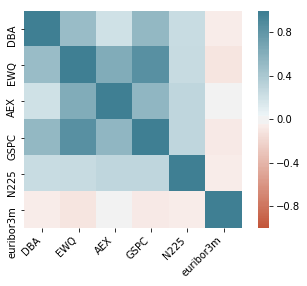

In [23]:
# Plot a correlation heatmap to observe correlations between assets
import seaborn as sns
corr = df_returns.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [24]:
# Set up lists containing the confidence levels
confidence_levels = [0.975, 0.99]

In [25]:
# Calculate the VaR and ES following the variance-covariance method
var_975_1d_varcov = VaR_SNorm(pf_std_euro, confidence_levels[0])
es_975_1d_varcov = ES_SNorm(pf_std_euro, confidence_levels[0])

In [26]:
print(f'VaR 97.5% 1d: {var_975_1d_varcov}, ES 97.5% 1d: {es_975_1d_varcov}')

VaR 97.5% 1d: 2538634.2322331113, ES 97.5% 1d: 3028028.189959515


In [27]:
var_990_1d_varcov = VaR_SNorm(pf_std_euro, confidence_levels[1])
es_990_1d_varcov = ES_SNorm(pf_std_euro, confidence_levels[1])

In [28]:
print(f'VaR 99% 1d: {var_990_1d_varcov}, ES 99% 1d: {es_990_1d_varcov}')

VaR 99% 1d: 3013191.260506098, ES 99% 1d: 3452106.3189802067


In [29]:
# check the distribution of the returns

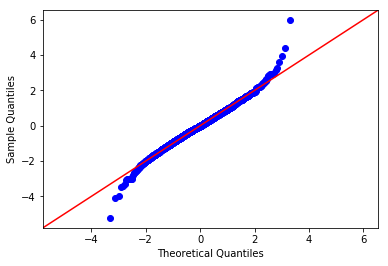

In [30]:
# DBA return distribution, against standard normal distribution
plot_qqplot(df_returns['DBA'], dist=stats.norm)

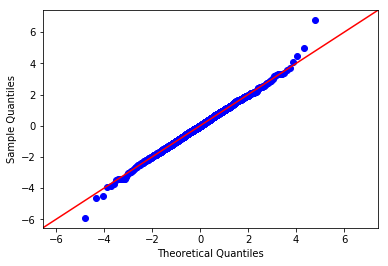

In [31]:
# DBA return distribution, with student-t distribution, df = 4
plot_qqplot(df_returns['DBA'], df = 4)

#### Estimate VaR and ES, based on Variance-Covariance method, Student-t distribution with 3, 4, 5, 6 degrees of freedom

In [32]:
# Make functions to calculate the VaR under a T-distribution
def VaR_Tdist(pf_std, confidence_level, df):
    alpha = (1-confidence_level)
    tppf = t.ppf(alpha, df)
    return t.ppf(confidence_level, df) * pf_std

# Make functions to calculate the ES under a T-distribution
def ES_Tdist(pf_std, confidence_level, df):
    alpha = (1-confidence_level)
    tppf = t.ppf(alpha, df)
    return -1/alpha * (1-df)**(-1) * (df-2+tppf**2) * t.pdf(tppf, df)*pf_std

In [33]:
from scipy.stats import t

In [34]:
# 3, 4, 5 and 6 degrees of freedom
degree_of_freedom = list(range(3,7))

In [35]:
# Calculate VaR with the variance-covariance method based on T-distribution at 97.5% confidence level
for df in degree_of_freedom:
    
    # Calculate VaR and ES for each degree of freedom
    var_975_1d_t= VaR_Tdist(pf_std_euro, confidence_levels[0], df)
    es_975_1d_t = ES_Tdist(pf_std_euro, confidence_levels[0], df)
    
    print(f'Student-t distribution with {df} degree of freedom: \nVaR 97.5% 1d: {np.round(var_975_1d_t,3)}, ES 97.5% 1d: {np.round(es_975_1d_t,3)}\n')

Student-t distribution with 3 degree of freedom: 
VaR 97.5% 1d: 4122048.771, ES 97.5% 1d: 5533054.988

Student-t distribution with 4 degree of freedom: 
VaR 97.5% 1d: 3596177.605, ES 97.5% 1d: 4289077.88

Student-t distribution with 5 degree of freedom: 
VaR 97.5% 1d: 3329534.164, ES 97.5% 1d: 3775409.082

Student-t distribution with 6 degree of freedom: 
VaR 97.5% 1d: 3169351.188, ES 97.5% 1d: 3513855.319



In [36]:
# compare with VaR and ES under standard normal distribution
print(f'VaR 97.5% 1d: {np.round(var_975_1d_varcov,3)}, ES 97.5% 1d: {np.round(es_975_1d_varcov,3)}')

VaR 97.5% 1d: 2538634.232, ES 97.5% 1d: 3028028.19


In [37]:
# Calculate VaR with the variance-covariance method based on T-distribution at 99% confidence level
for df in degree_of_freedom:
    
    var_990_1d_t= VaR_Tdist(pf_std_euro, confidence_levels[1], df)
    es_990_1d_t = ES_Tdist(pf_std_euro, confidence_levels[1], df)
    
    print(f'Student-t distribution with {df} degree of freedom: \nVaR 99.0% 1d: {np.round(var_990_1d_t,3)}, ES 99.0% 1d: {np.round(es_990_1d_t,3)}\n')

Student-t distribution with 3 degree of freedom: 
VaR 99.0% 1d: 5881324.252, ES 99.0% 1d: 8302590.519

Student-t distribution with 4 degree of freedom: 
VaR 99.0% 1d: 4853216.172, ES 99.0% 1d: 6012260.914

Student-t distribution with 5 degree of freedom: 
VaR 99.0% 1d: 4358409.926, ES 99.0% 1d: 5060368.593

Student-t distribution with 6 degree of freedom: 
VaR 99.0% 1d: 4070526.628, ES 99.0% 1d: 4565139.33



In [38]:
# Compare with VaR and ES under standard normal distribution
print(f'VaR 99% 1d: {np.round(var_990_1d_t,3)}, ES 99% 1d: {np.round(es_990_1d_t,3)}')

VaR 99% 1d: 4070526.628, ES 99% 1d: 4565139.33


#### Estimate VaR and ES, based on Historical Simulation method

In [39]:
# Calculate the historical losses, and order them in increasing order
pf_losses = -((df_returns.mul(weights, axis=1)).sum(axis = 1))
pf_losses = pf_losses[~pd.isnull(pf_losses)]

In [40]:
# Calculate the VaR and ES following the historical simulation method at 97.5% confidence
var_975_1d_hsm = np.percentile(pf_losses[start:split_date],confidence_levels[0]*100)
es_975_1d_hsm = pf_losses[start:split_date][pf_losses >= var_975_1d_hsm].mean()

In [41]:
print(f'VaR 97.5% 1d: {np.round(var_975_1d_hsm,3)}, ES 97.5% 1d: {np.round(es_975_1d_hsm,3)}')

VaR 97.5% 1d: 3114147.007, ES 97.5% 1d: 3481342.015


In [42]:
# Calculate the VaR and ES following the historical simulation method at 99% confidence
var_990_1d_hsm = np.percentile(pf_losses[start:split_date],confidence_levels[1]*100)
es_990_1d_hsm = pf_losses[start:split_date][pf_losses >= var_990_1d_hsm].mean()

In [43]:
print(f'VaR 99% 1d: {np.round(var_990_1d_hsm,3)}, ES 99% 1d: {np.round(es_990_1d_hsm,3)}')

VaR 99% 1d: 3511126.307, ES 99% 1d: 3684353.435


#### Estimate VaR and ES, based on Filtered Historical Simulation method with EWMA for each risk factor ####

In [44]:
from arch import arch_model as am
from arch.univariate import EWMAVariance
from arch.univariate import ZeroMean

In [45]:
# an alternative way to estimate the conditional volatility with EWMA model


# def CalculateEWMAVol (ReturnSeries, lmbd, avg_assumed_zero = True):   
#     SampleSize = len(ReturnSeries)
    
#     # under the default setting, the average return is assumed 0
#     Average = ReturnSeries.mean() if avg_assumed_zero == False else 0

#     k = np.arange(SampleSize-1,-1,-1)
#     L = np.repeat(lmbd,SampleSize)
    
#     vecLambda = np.power(L,k)
#     sqrd_ret = np.power(ReturnSeries-Average,2)

#     sumEWM = (sqrd_ret*vecLambda).sum()
#     Variance_t = sumEWM/vecLambda.sum()
#     volEWMA = np.sqrt(Variance_t)

#     return (volEWMA)

# def CalculateVol (ReturnDataframe, lmbd):
#     '''
#     given the information up untill t-1 in ReturnDataframe, this function returns the volatility at t
#     '''
#     Vol = pd.Series(index=ReturnDataframe.columns)
#     for instrument in ReturnDataframe.columns:
#         Vol[instrument] = CalculateEWMAVol(ReturnDataframe[instrument], lmbd)
#     return (Vol)

In [46]:
def CalculateConditionalVolEWMA(ReturnDataframe,lmbd=0.94):
    '''
    estimate the conditional volatility with EWMA model
    
    '''
    rm = EWMAVariance(lmdb)
    con_volEWMA = pd.DataFrame(columns=ReturnDataframe.columns)
    for ins in ReturnDataframe.columns:
        con_volEWMA[ins] = np.sqrt(ZeroMean(ReturnDataframe[ins],volatility=rm).fit().conditional_volatility)


    return con_volEWMA

In [47]:
def CalculateStandardizedResiduals(ReturnDataframe, ConVolDataframe):
    '''
    generate the standardized the residuals for return simulations
    '''
    return ReturnDataframe/ConVolDataframe

In [48]:
def CalculateRiskMeasureFHS(StandardizedResiduals, ConVolDataframe, ConfidenceInterval, weights, risk_measure):
    '''
    StandardizedResiduals: estimated standardized residuals from the estimation period -> df
    
    ConVolDataframe: estimated conditional volatility from the testing period -> df
    
    ConfidenceInterval: confidence interval for VaR -> float
    
    This function returns a df containing the VaR based on the Filtered Historical Simulation Method
    
    risk_measure: var or es -> string
    '''

    if risk_measure == 'var':
        sim_ret = pd.DataFrame(columns=ConVolDataframe.columns)
        VaR_FHS=[]

        # iterate through the instruments
        for i in range(len(ConVolDataframe)):

            # calculate the simulated returns, which is the product of the estimated standardized residuals from the training set
            # and the conditional volatility of the corresponding industry and date
            sim_ret = (StandardizedResiduals*ConVolDataframe.iloc[i])

            loss = - sim_ret.mul(weights, axis = 1).sum(axis=1)

            temp = np.percentile(loss,int(ConfidenceInterval*100))

            VaR_FHS.append(temp)

        VaR_FHS = pd.Series(data=VaR_FHS, index=ConVolDataframe.index)
        result = VaR_FHS
    
    
    elif risk_measure == 'es':
        
        sim_ret = pd.DataFrame(columns=ConVolDataframe.columns)
        ES_FHS=[]

        # iterate through the instruments
        for i in range(len(ConVolDataframe)):

            # calculate the simulated returns, which is the product of the estimated standardized residuals from the training set
            # and the conditional volatility of the corresponding industry and date
            
            sim_ret = (StandardizedResiduals*ConVolDataframe.iloc[i])

            loss = - sim_ret.mul(weights, axis = 1).sum(axis=1)

            temp = np.percentile(loss,int(ConfidenceInterval*100))

            es_temp = loss[loss >= temp].mean()
            
            ES_FHS.append(es_temp)

        ES_FHS = pd.Series(data=ES_FHS, index=ConVolDataframe.index)
        result = ES_FHS
    
    
    else:
        print('Wrong risk measure input.')
    
    return result

In [49]:
# Calculate the conditional volatility in a non-rolling window 
con_volEWMA_train = CalculateConditionalVolEWMA(train_set)
con_volEWMA_test = CalculateConditionalVolEWMA(test_set)

In [50]:
std_resid_train = CalculateStandardizedResiduals(train_set, con_volEWMA_train)

In [51]:
var_975_1d_fhs = CalculateRiskMeasureFHS(std_resid_train, con_volEWMA_test, confidence_levels[0], weights, 'var')
var_990_1d_fhs = CalculateRiskMeasureFHS(std_resid_train, con_volEWMA_test, confidence_levels[1], weights, 'var')

In [52]:
es_975_1d_fhs = CalculateRiskMeasureFHS(std_resid_train, con_volEWMA_test, confidence_levels[0], weights, 'es')
es_990_1d_fhs = CalculateRiskMeasureFHS(std_resid_train, con_volEWMA_test, confidence_levels[1], weights, 'es')

In [53]:
con_volEWMA_test.head()

,DBA,EWQ,AEX,GSPC,N225,euribor3m
Date,,,,,,
2012-01-05,1.170494e+06,1.698627e+06,890121.329726,855396.246249,1.496126e+06,25803.447644
2012-01-06,1.367980e+06,1.813695e+06,886812.861474,845182.056485,1.515849e+06,26474.999789
2012-01-11,1.360012e+06,1.889367e+06,862152.959158,879688.220190,1.524466e+06,25787.484862
2012-01-12,1.318911e+06,1.834339e+06,888345.610101,853766.432054,1.478398e+06,25487.141510
2012-01-13,1.347489e+06,1.789173e+06,867822.630650,827764.671286,1.453039e+06,25473.163412


### Estimate VaR and ES, based on Constant Conditional Correlation method

In [54]:
# Fill empty cells
df_returns = df_returns.ffill().iloc[1:,:]
train_set = train_set.ffill().iloc[1:,:]

returns = df_returns

In [55]:
# In the rolling window estimation each model is reestimated yearly on the previous two years of data. 
# The list 'split_dates' is used to iterate over in a rolling window fashion

import collections

# This kind of dict lets you initiate a key and append to it simultaneously 
rolling_var = collections.defaultdict(list)

rolling_es = collections.defaultdict(list)

# Store forecasted conditional volatilities on a rolling window basis
rolling_forecasted_volatilities = pd.DataFrame()

# Store rolling correlation matrix
rolling_corr_matrix = collections.defaultdict(list)

# Temporary list for series of FHS VaRs and ESs
var_975_fhs_rolling = []
var_990_fhs_rolling = []

es_975_fhs_rolling = []
es_990_fhs_rolling = []

# Year 1 and 2 are used to estimate the VaR for year 3
# Year 2 and 3 are used to estimate the VaR for year 4
# Etc.

for i in range(len(split_dates) - 3):
    
    # Estimate covariance matrix on windows of two years
    cov_matrix = df_returns[split_dates[i] : split_dates[i+2]].cov()
    pf_std_euro = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    # Calculate VaR with var-covar method
    var975 = VaR_SNorm(pf_std_euro, confidence_levels[0])
    var990 = VaR_SNorm(pf_std_euro, confidence_levels[1])
    # Calculate ES with var-covar method    
    es975 = ES_SNorm(pf_std_euro, confidence_levels[0])
    es990 = ES_SNorm(pf_std_euro, confidence_levels[1])
    
    # Append to dict
    rolling_var['var975varcov'].append(var975)
    rolling_var['var990varcov'].append(var990)
    
    rolling_es['es975varcov'].append(es975)
    rolling_es['es990varcov'].append(es990)
    
    # Calculate VaR with var-covar method with t-distribution
    
    # 3, 4, 5 and 6 degrees of freedom
    degree_of_freedom = list(range(3,7))
    
    for df in degree_of_freedom:
        
        # Calculate VaR and ES with var-covar and t-distribution method
        var_975_t= VaR_Tdist(pf_std_euro, confidence_levels[0], df)
        var_990_t= VaR_Tdist(pf_std_euro, confidence_levels[1], df)
        
        es_975_t = ES_Tdist(pf_std_euro, confidence_levels[0], df)
        es_990_t = ES_Tdist(pf_std_euro, confidence_levels[1], df)
        
        # Append to dict
        rolling_var['var975t_df' + str(df)].append(var_975_t)
        rolling_var['var990t_df' + str(df)].append(var_990_t)
        
        rolling_es['es975t_df' + str(df)].append(es_975_t)
        rolling_es['es990t_df' + str(df)].append(es_990_t)
        
    # Calculate VaR and ES with historical simulation method
    var_975_hsm = np.percentile(pf_losses[split_dates[i] : split_dates[i+2]], confidence_levels[0] * 100)
    var_990_hsm = np.percentile(pf_losses[split_dates[i] : split_dates[i+2]], confidence_levels[1] * 100)
    
    es_975_1d_hsm = pf_losses[split_dates[i] : split_dates[i+2]][pf_losses >= var_975_hsm].mean()
    es_990_1d_hsm = pf_losses[split_dates[i] : split_dates[i+2]][pf_losses >= var_990_hsm].mean()
    
    # Append to dict
    rolling_var['var975hsm'].append(var_975_hsm)
    rolling_var['var990hsm'].append(var_990_hsm)
    
    rolling_es['es975hsm'].append(es_975_1d_hsm)
    rolling_es['es990hsm'].append(es_990_1d_hsm)
    
    # Forecast volatilities with a rolling window using a GARCH(1,1)
    forecasted_volatility = pd.DataFrame(index=df_returns[split_dates[i+2]:split_dates[i+3]].index)
    cons_corr2 = df_returns[split_dates[0] : split_dates[2]].corr()
    
    for instrument in returns.columns:

        garch11 = arch_model(returns[instrument], p=1, q=1, dist='Normal', vol='Garch')
        res = garch11.fit(update_freq=10, last_obs=split_dates[i+2], disp='off')
        forecasts = res.forecast(horizon=1, start=split_dates[i+2])
        forecasted_variance = forecasts.variance[split_dates[i+2]:split_dates[i+3]]
        forecasted_volatility[instrument] = np.sqrt(forecasted_variance)

        
    # Append the forecasted year to the rolling_forecasted_volatilities dataframe
    rolling_forecasted_volatilities = rolling_forecasted_volatilities.append(forecasted_volatility)
    
    # Append rolling correlation matrix to list
    rolling_corr = df_returns[split_dates[i]:split_dates[i+2]].corr()
    rolling_corr_matrix[split_dates[i+3]].append(rolling_corr)
    
    # Forecast volatilities with a rolling window using EWMA
    con_volEWMA_train = CalculateConditionalVolEWMA(df_returns[split_dates[i] : split_dates[i+2]])
    con_volEWMA_test = CalculateConditionalVolEWMA(df_returns[split_dates[i+2] : split_dates[i+3]])

    std_resid_train = CalculateStandardizedResiduals(df_returns[split_dates[i] : split_dates[i+2]], con_volEWMA_train)
    
    # Calculate the series of VaRs 
    var_975_1d_fhs_rolling = CalculateRiskMeasureFHS(std_resid_train, con_volEWMA_test, confidence_levels[0], weights, 'var')
    var_990_1d_fhs_rolling = CalculateRiskMeasureFHS(std_resid_train, con_volEWMA_test, confidence_levels[1], weights, 'var')
    
    es_975_1d_fhs_rolling = CalculateRiskMeasureFHS(std_resid_train, con_volEWMA_test, confidence_levels[0], weights, 'es')
    es_990_1d_fhs_rolling = CalculateRiskMeasureFHS(std_resid_train, con_volEWMA_test, confidence_levels[1], weights, 'es')
    
    # Store each series of VaRs and ESs in a temporary list
    var_975_fhs_rolling.append(var_975_1d_fhs_rolling)
    var_990_fhs_rolling.append(var_990_1d_fhs_rolling)
    
    es_975_fhs_rolling.append(es_975_1d_fhs_rolling)
    es_990_fhs_rolling.append(es_990_1d_fhs_rolling)    
     
# Concatenate the list of series and append to the VaRs dict
rolling_var['var975fhs'].append(pd.concat(var_975_fhs_rolling))
rolling_var['var990fhs'].append(pd.concat(var_990_fhs_rolling))

# Concatenate the list of series and append to the ESs dict
rolling_es['es975fhs'].append(pd.concat(es_975_fhs_rolling))
rolling_es['es990fhs'].append(pd.concat(es_990_fhs_rolling))

# Finally, the VaR and ES measures can be found in the respective dictionaries

In [56]:
# Use the conditional volatilities and correlations matrices to calculate the VaR and ES
# The approach is similar to the var-covar method in that the covariance matrix is used
# to calculate VaR and ES.

var_975_1d_ccc = []
var_990_1d_ccc = []
es_975_1d_ccc = []
es_990_1d_ccc = []

for index, row in rolling_forecasted_volatilities.iterrows():
    
    # For each conditional volatility in the dataframe calculate the VaR and ES
    vola = np.array(row)
    
    # Refresh the correlation matrix each year 
    for date in list(rolling_corr_matrix.keys())[0:7]:
        if index < dt.date.fromisoformat(date):
            cons_corr = rolling_corr_matrix.get(date)
            break
    
    cov = vola * vola * cons_corr[0]
    ccc_std_euro = np.sqrt(weights.T.dot(cov).dot(weights))
    
    var_975_1d_ccc_value = VaR_SNorm(ccc_std_euro, confidence_levels[0])
    var_990_1d_ccc_value = VaR_SNorm(ccc_std_euro, confidence_levels[1])
    
    es_975_1d_ccc_value = ES_SNorm(ccc_std_euro, confidence_levels[0])
    es_990_1d_ccc_value = ES_SNorm(ccc_std_euro, confidence_levels[1])
    
    var_975_1d_ccc.append(var_975_1d_ccc_value)
    var_990_1d_ccc.append(var_990_1d_ccc_value)
    
    es_975_1d_ccc.append(es_975_1d_ccc_value)
    es_990_1d_ccc.append(es_990_1d_ccc_value)

In [57]:
# Store estimates in dataframe
ccc = pd.DataFrame(data=[var_975_1d_ccc, var_990_1d_ccc, es_975_1d_ccc, es_990_1d_ccc]).transpose()
ccc = ccc.set_index(df_returns[split_date:end].index)
ccc.columns = ['var_975_1d_ccc', 'var_990_1d_ccc', 'es_975_1d_ccc', 'es_990_1d_ccc']

ccc.head()

,var_975_1d_ccc,var_990_1d_ccc,es_975_1d_ccc,es_990_1d_ccc
Date,,,,
2012-01-02,2.192399e+06,2.602233e+06,2.615046e+06,2.981286e+06
2012-01-03,2.119507e+06,2.515714e+06,2.528102e+06,2.882165e+06
2012-01-04,2.077185e+06,2.465482e+06,2.477622e+06,2.824615e+06
2012-01-05,2.188744e+06,2.597894e+06,2.610686e+06,2.976315e+06
2012-01-06,2.215543e+06,2.629703e+06,2.642652e+06,3.012758e+06


In [58]:
# Append CCC VaRs to dict
rolling_var['var975ccc'].append(ccc['var_975_1d_ccc'])
rolling_var['var990ccc'].append(ccc['var_990_1d_ccc'])

rolling_es['es975ccc'].append(ccc['es_975_1d_ccc'])
rolling_es['es990ccc'].append(ccc['es_990_1d_ccc'])

### Backtest previously constructed VaR systems ###

In [59]:
# Backtest in the testing period, which is split_date until end date
backtest = pd.DataFrame(data=[pf_losses[split_date:end]]).T
backtest.columns = ['Losses']

# Add the time-varying VaRs of the conditional methods

backtest['var975ccc'] = rolling_var['var975ccc'][0]
backtest['var990ccc'] = rolling_var['var990ccc'][0]
backtest['var975fhs'] = rolling_var['var975fhs'][0]
backtest['var990fhs'] = rolling_var['var990fhs'][0]

# Add the constant VaRs of the unconditional methods

for i in rolling_var:
    string = (str(i)[len(str(i))-3:len(str(i))])
    if (string != 'ccc'):
        if (string != 'fhs'):
            if (string != '0'):
                backtest[i] = ''
                for j in range(len(split_dates) - 3):
                    backtest[i][split_dates[j+2] : split_dates[j+3]] = rolling_var.get(i)[j]


backtest= backtest.astype(float)

## $ T(N)= {{\sum^N_{t=1} I_t-N(1 - \alpha)} \over \sqrt{N \alpha (1-\alpha)}} \sim N(0,1) $ ##

In [60]:
# Initialize dataframe to store test statistics
zscores = pd.DataFrame()

# Initialize dict to store pvalues
var_pvalues = {}

# For each measure, add a column that only contains the losses that violated the corresponding VaR
for measure in backtest.iloc[:,1:]:
    
    # Define column name for the violation colums per method
    measure_violation = str(measure) + '_violations'
    
    backtest[measure_violation] = np.where(backtest['Losses'] > backtest[measure], backtest['Losses'], 'NaN')
    backtest[measure_violation] = backtest[measure_violation].astype(float)
    
    # Apply appropriate alpha
    if measure[3:6] == '975':
        alpha = (1-confidence_levels[0])
    elif measure[3:6] == '990':
        alpha = (1-confidence_levels[1])
    
    # Calculate test statistic based on markdown above
    N = len(backtest)
    violations = backtest[measure_violation].count()
    expected = N * (alpha)
    
    zscore = (violations - expected) / np.sqrt(N * alpha * (1 - alpha))
    pvalue = norm.sf(abs(zscore)) * 2    # P-value is two sided
    
    var_pvalues[measure] = pvalue
    
    zscores[measure] = [zscore, pvalue]
    
    print (measure)
    print ('Z-score: {:.3f}'.format(zscore))
    print ('P-value: {:.3f}'.format(pvalue))
    print ()

var975ccc
Z-score: -3.253
P-value: 0.001

var990ccc
Z-score: -2.566
P-value: 0.010

var975fhs
Z-score: 1.611
P-value: 0.107

var990fhs
Z-score: -0.420
P-value: 0.675

var975varcov
Z-score: -0.517
P-value: 0.605

var990varcov
Z-score: 0.773
P-value: 0.440

var975t_df3
Z-score: -5.532
P-value: 0.000

var990t_df3
Z-score: -3.759
P-value: 0.000

var975t_df4
Z-score: -4.772
P-value: 0.000

var990t_df4
Z-score: -2.805
P-value: 0.005

var975t_df5
Z-score: -4.316
P-value: 0.000

var990t_df5
Z-score: -2.328
P-value: 0.020

var975t_df6
Z-score: -4.164
P-value: 0.000

var990t_df6
Z-score: -2.089
P-value: 0.037

var975hsm
Z-score: -1.277
P-value: 0.202

var990hsm
Z-score: -0.420
P-value: 0.675



In [61]:
zscores = zscores.transpose()
zscores.columns = ['Z-score', 'P-value']
zscores

,Z-score,P-value
var975ccc,-3.252520,1.143865e-03
var990ccc,-2.566098,1.028498e-02
var975fhs,1.611061,1.071664e-01
var990fhs,-0.419733,6.746802e-01
var975varcov,-0.516756,6.053268e-01
var990varcov,0.772691,4.397052e-01
var975t_df3,-5.532324,3.160158e-08
var990t_df3,-3.758522,1.709198e-04
var975t_df4,-4.772389,1.820533e-06
var990t_df4,-2.804583,5.038177e-03


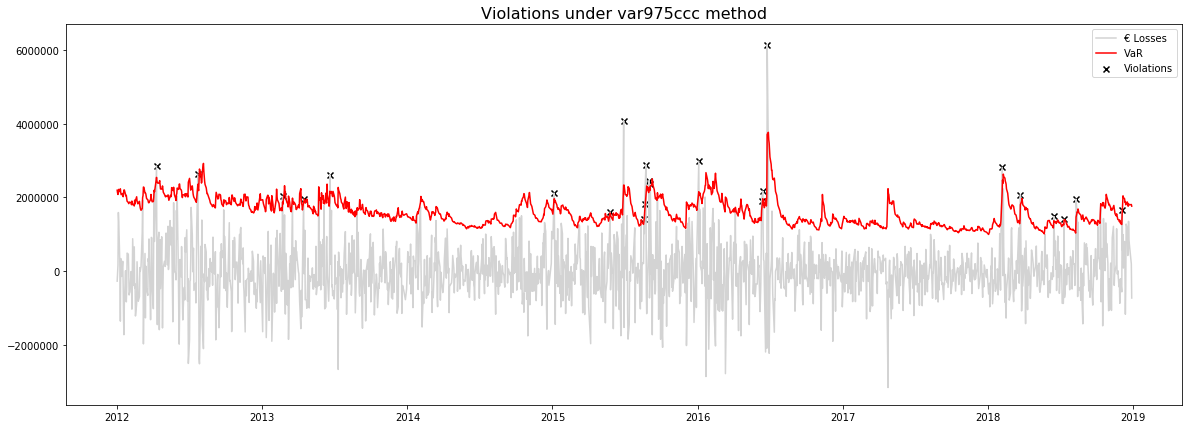

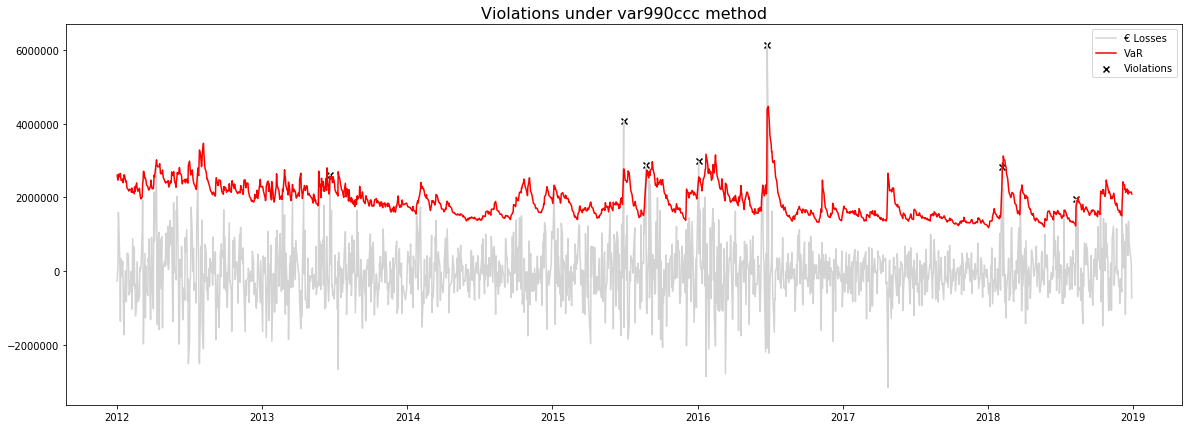

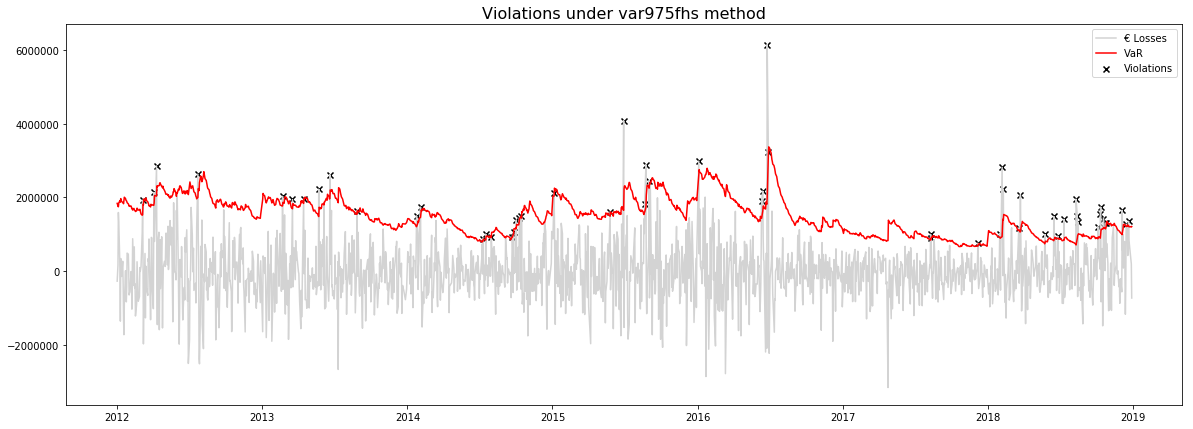

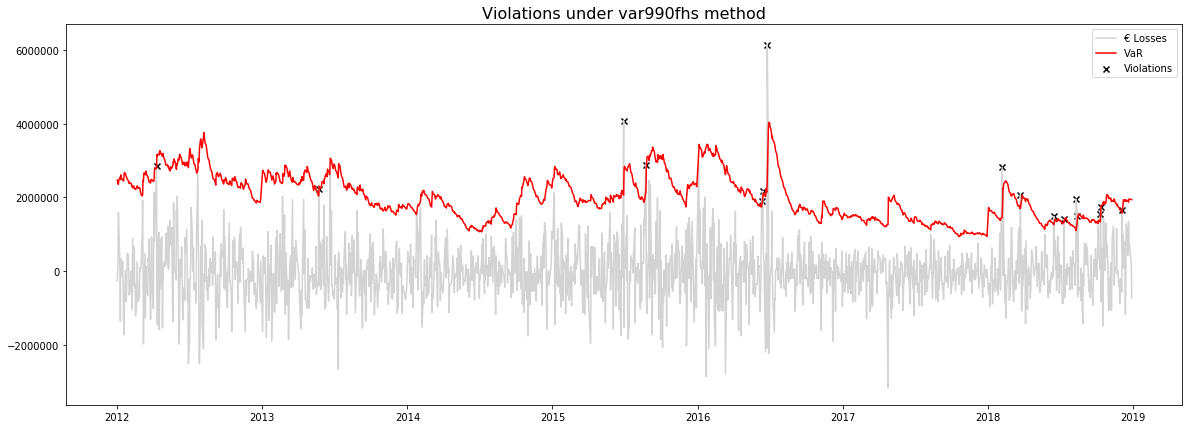

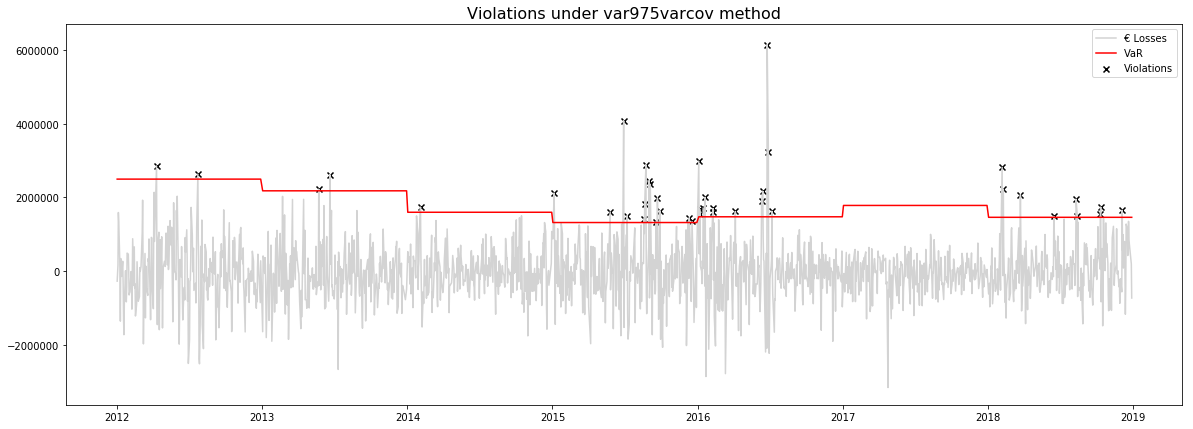

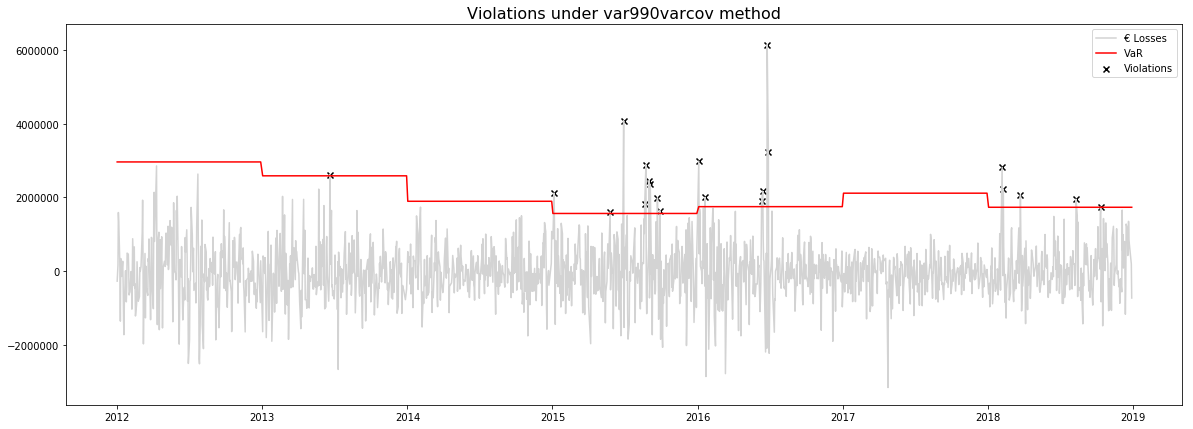

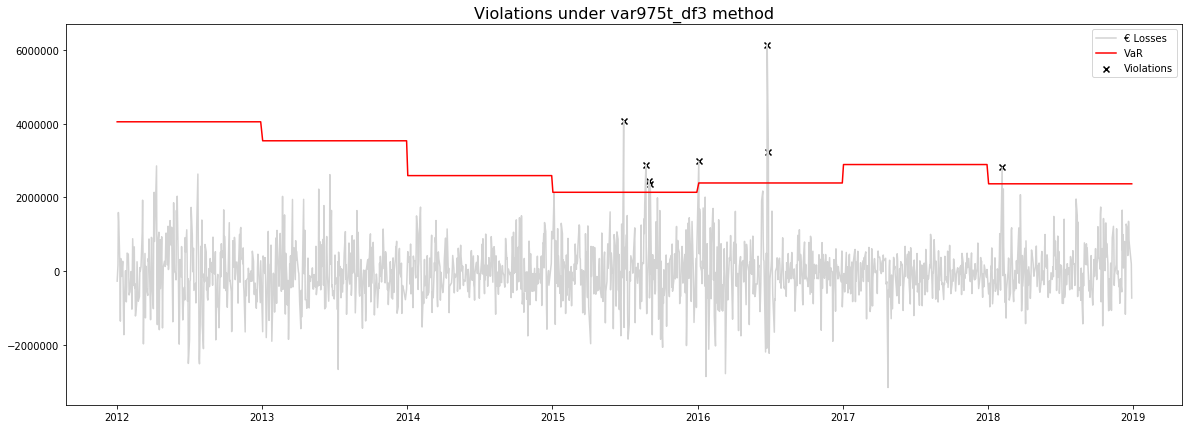

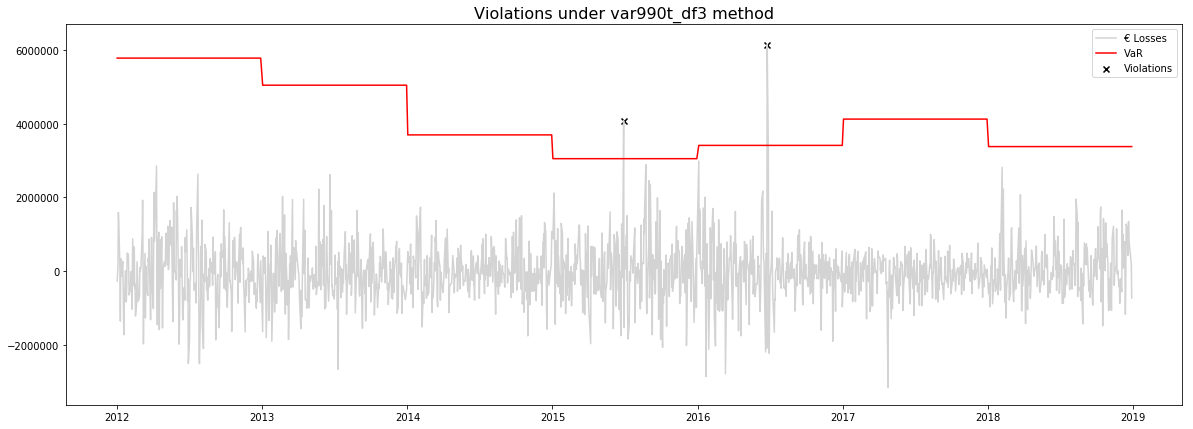

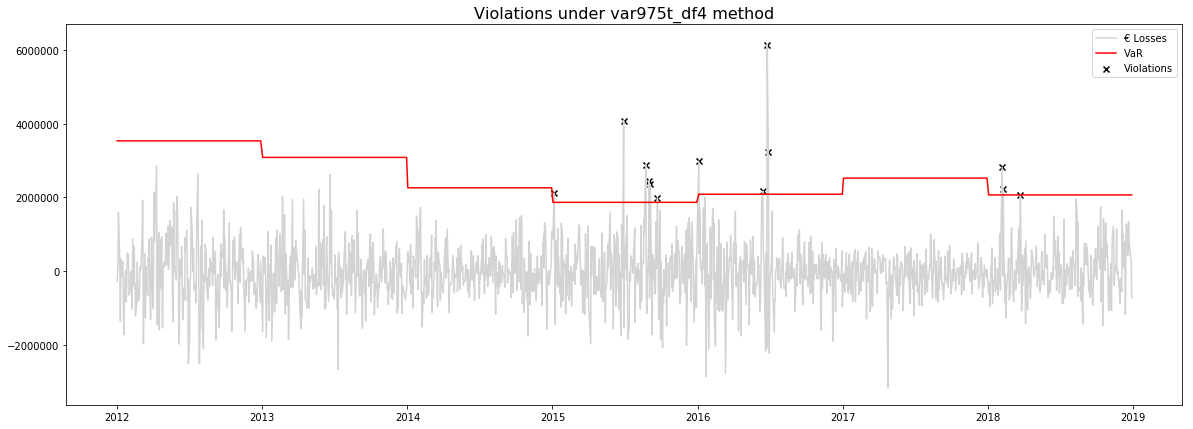

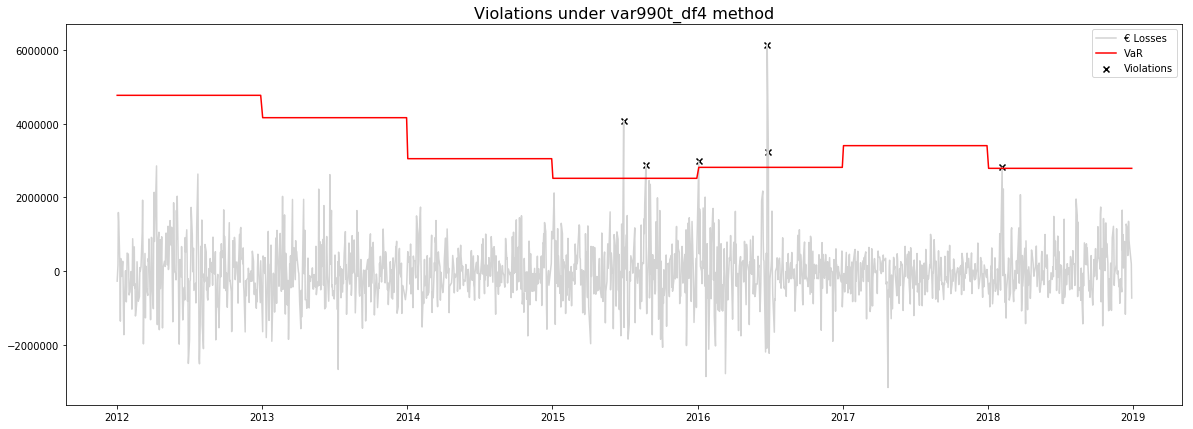

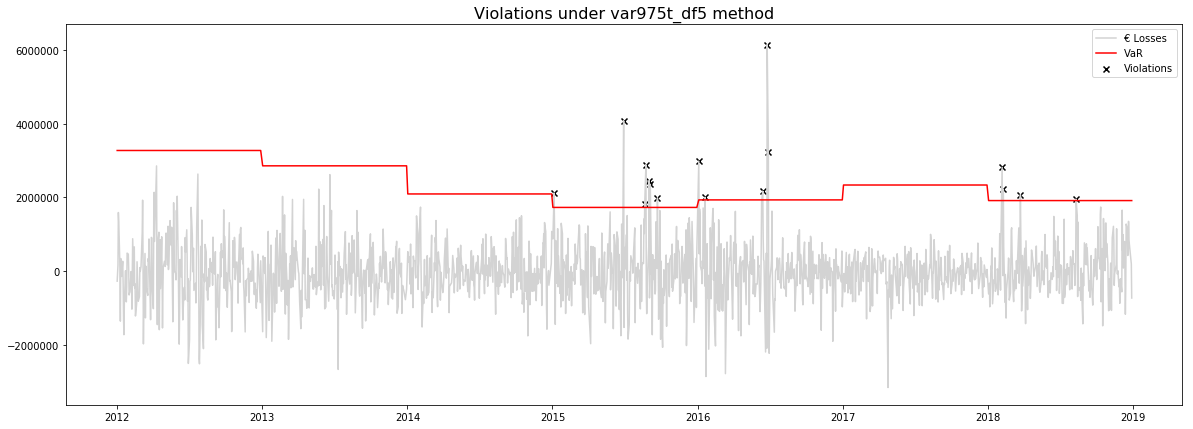

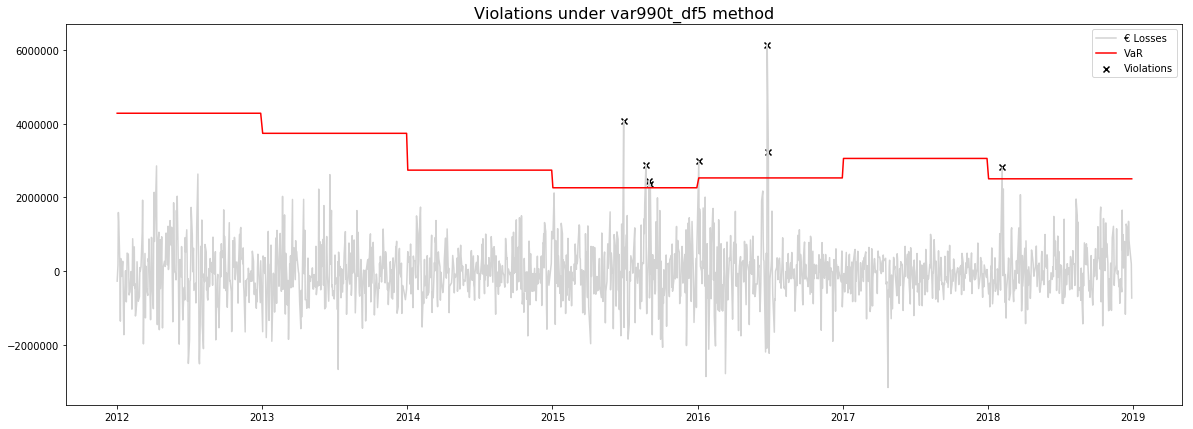

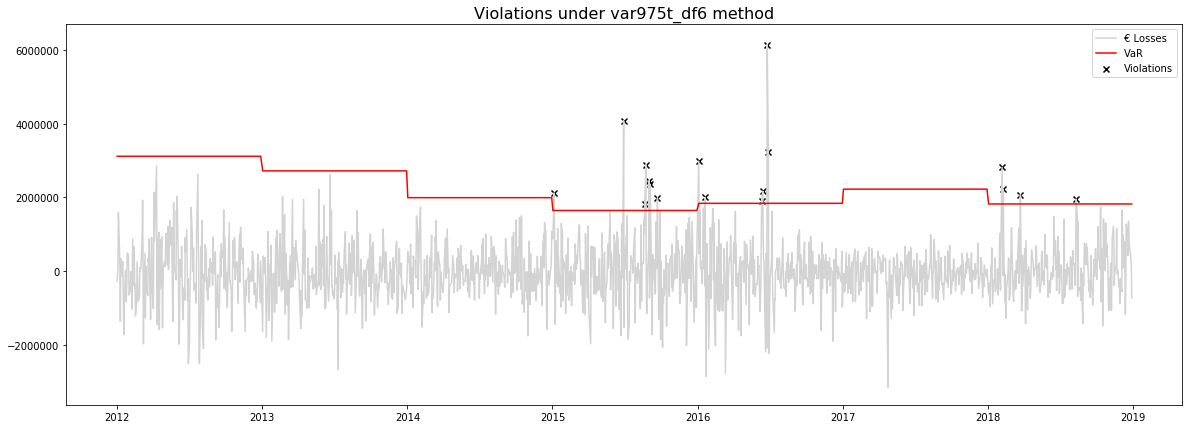

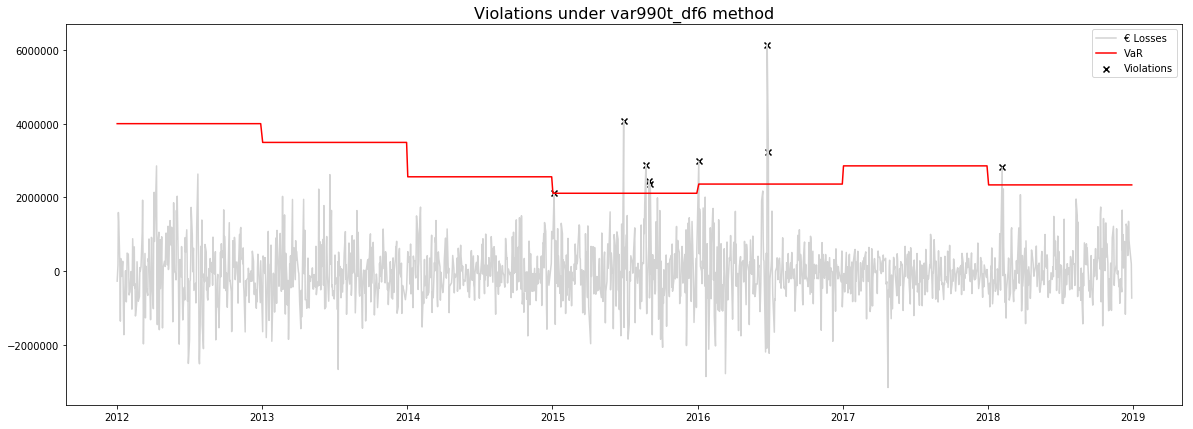

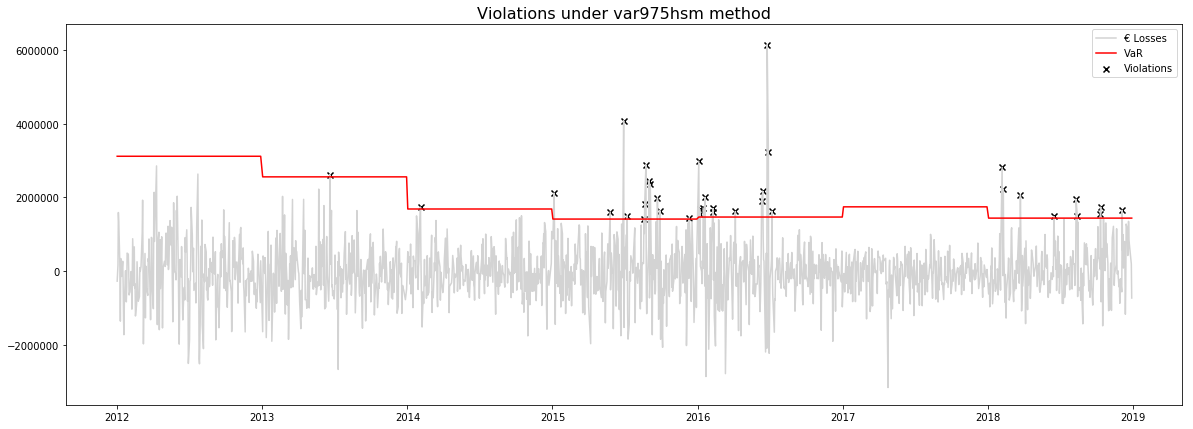

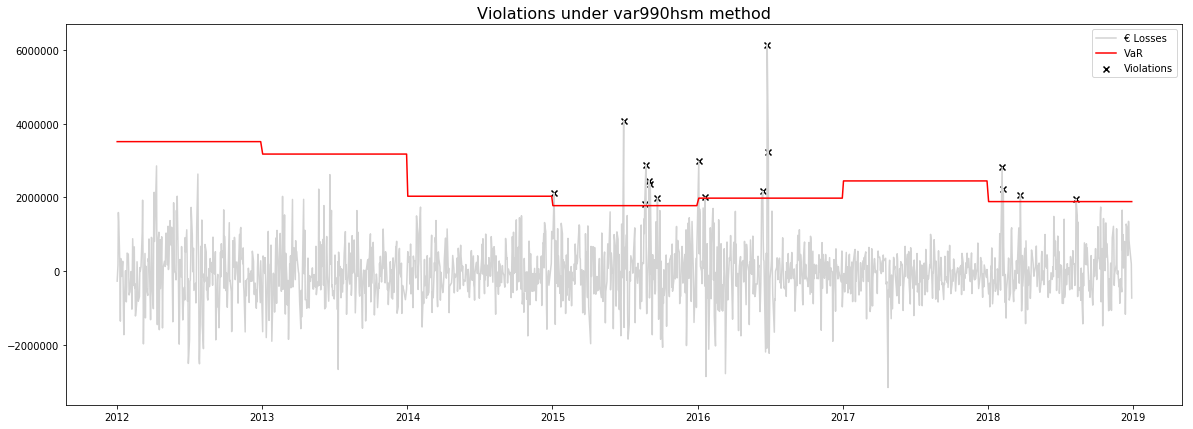

In [62]:
# Plot violations to observe clustering
for measure in backtest.iloc[:,1:17]:

    measure_violation = str(measure) + '_violations'
    
    # Use the backtest period as index
    x = backtest.index
    y1 = backtest['Losses']
    y2 = backtest[measure_violation]
    y3 = backtest[measure]
    
    fig, ax = plt.subplots(figsize=(20, 7))

    plt.title('Violations under {} method'.format(measure), size=16)

    # Plot returns in euro
    plt.plot(x, y1, color='lightgrey', label = '\u20ac Losses')
    
    # Mark the violations
    plt.scatter(x, y2, marker='x', color='black', label = 'Violations')
    
    # Plot VaR
    plt.plot(x, y3, color='red', label = 'VaR')
        
    plt.legend();

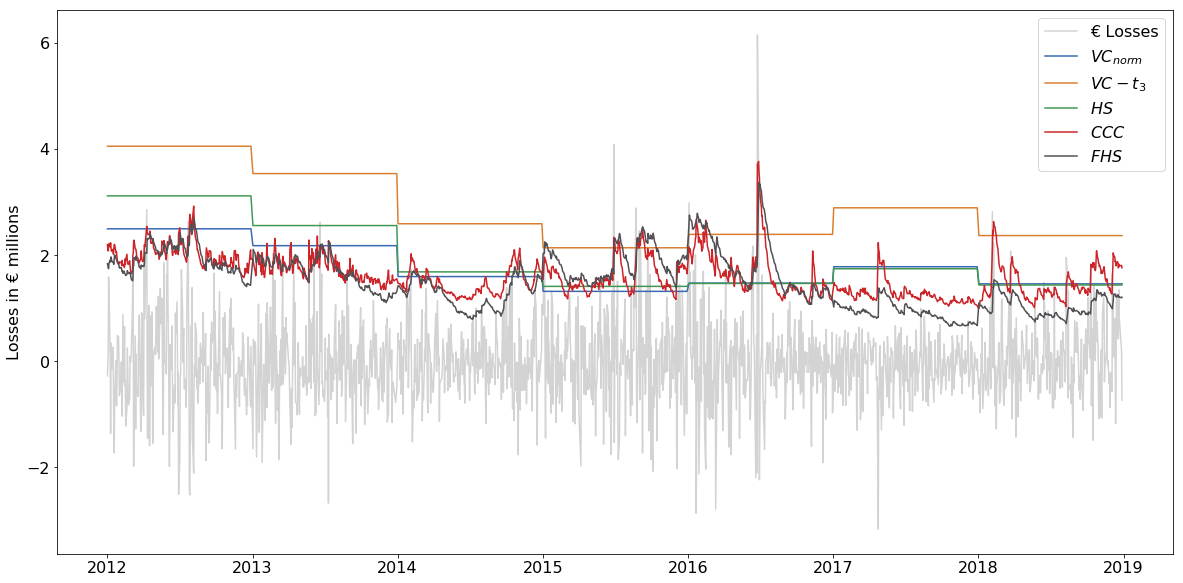

In [63]:
# Plot several VaRs in one figure

backtest[['Losses', 'var975varcov', 'var975t_df3', 'var975hsm', 'var975ccc', 'var975fhs']]

x = backtest.index
y1 = backtest['Losses'] / 1000000
y2 = backtest['var975varcov'] / 1000000
y3 = backtest['var975t_df3'] / 1000000
y4 = backtest['var975hsm'] / 1000000
y5 = backtest['var975ccc'] / 1000000
y6 = backtest['var975fhs'] / 1000000

fig, ax = plt.subplots(figsize=(20, 10))

plt.ylabel('Losses in \u20ac millions', size=16)
plt.tick_params(labelsize=16)

# Plot returns in euro
plt.plot(x, y1, color='lightgrey', label = '\u20ac Losses')
plt.plot(x, y2, color='#3869B1', label = '$VC_{norm}$')
plt.plot(x, y3, color='#DA7E30', label = '$VC-t_3$')
plt.plot(x, y4, color='#3F9852', label = '$HS$')
plt.plot(x, y5, color='#CC2428', label = '$CCC$')
plt.plot(x, y6, color='#535055', label = '$FHS$')

plt.legend(fontsize=16);

#plt.savefig('var_975_overtime', dpi=400, bbox_inches='tight')

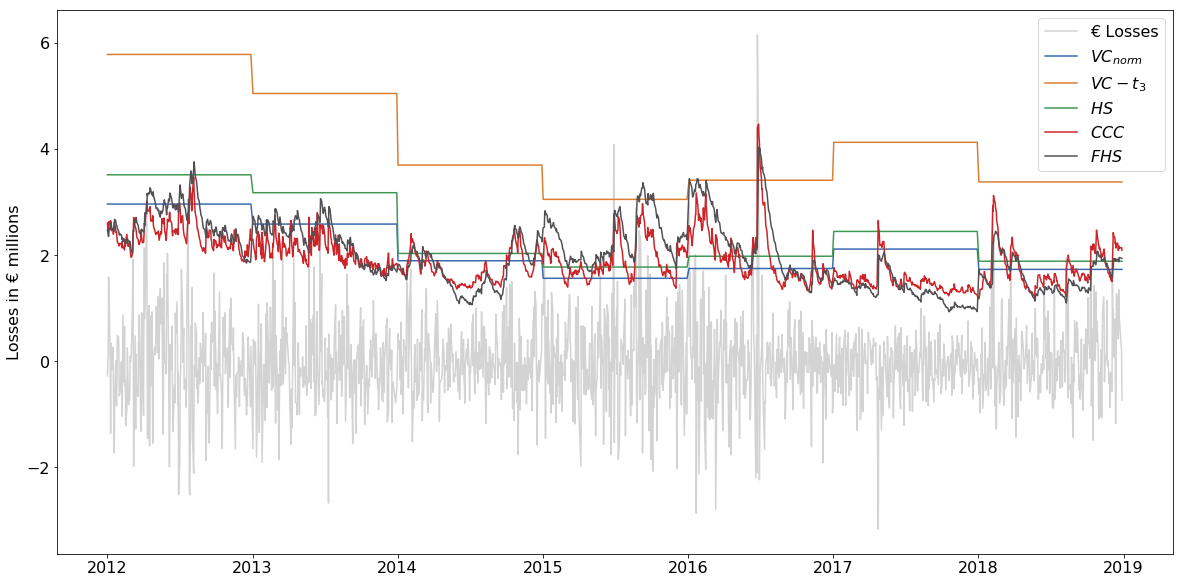

In [64]:
# Gather data for figure 1 in the report
backtest[['Losses', 'var975varcov', 'var975t_df3', 'var975hsm', 'var975ccc', 'var975fhs']]

x = backtest.index
y1 = backtest['Losses'] / 1000000
y2 = backtest['var990varcov'] / 1000000
y3 = backtest['var990t_df3'] / 1000000
y4 = backtest['var990hsm'] / 1000000
y5 = backtest['var990ccc'] / 1000000
y6 = backtest['var990fhs'] / 1000000

fig, ax = plt.subplots(figsize=(20, 10))

plt.ylabel('Losses in \u20ac millions', size=16)
plt.tick_params(labelsize=16)

# Plot returns in euro
plt.plot(x, y1, color='lightgrey', label = '\u20ac Losses')
plt.plot(x, y2, color='#3869B1', label = '$VC_{norm}$')
plt.plot(x, y3, color='#DA7E30', label = '$VC-t_3$')
plt.plot(x, y4, color='#3F9852', label = '$HS$')
plt.plot(x, y5, color='#CC2428', label = '$CCC$')
plt.plot(x, y6, color='#535055', label = '$FHS$')

plt.legend(fontsize=16);

#plt.savefig('var_990_overtime', dpi=400, bbox_inches='tight')

In [65]:
# Define a function to plot Q-Q plots
def plot_qqplot(ReturnSeries,df=3, dist = stats.t):
    
    ReturnSeries = ReturnSeries.dropna()
    if dist==stats.t:
        fig1 = qqplot(ReturnSeries, line='45', dist = dist, fit = True, distargs=(df,))
    if dist == stats.norm:
        fig1 = qqplot(ReturnSeries, line='45', dist = dist, fit = True)

    return

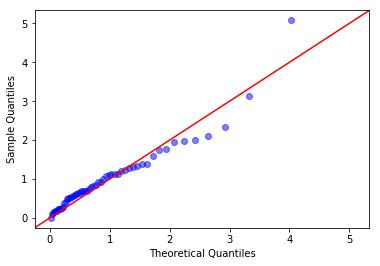

In [66]:
# Plot violations of the filtered historical simulation method against the exponential distribution
fig = qqplot(backtest['var975fhs_violations'].dropna(), line='45', dist=stats.expon, fit=True);

# Grab the lines with blue dots
dots = fig.findobj(lambda x: hasattr(x, 'get_color') and x.get_color() == 'b')

[d.set_alpha(0.5) for d in dots]

plt.savefig('fhs975qqplot', dpi=400, bbox_inches='tight')

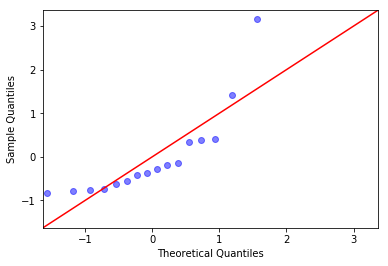

In [67]:
fig = qqplot(backtest['var990fhs_violations'].dropna(), line='45', dist=stats.norm, fit=True);

# Grab the lines with blue dots
dots = fig.findobj(lambda x: hasattr(x, 'get_color') and x.get_color() == 'b')

[d.set_alpha(0.5) for d in dots]

plt.savefig('fhs990qqplot', dpi=400, bbox_inches='tight')

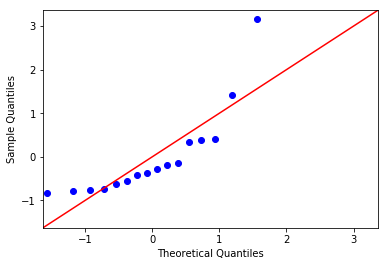

In [68]:
plot_qqplot(backtest['var990fhs_violations'], dist=stats.norm)

In [69]:
# Repeat the backtesting procedure for Expected Shortfall (ES)
backtest_es = pd.DataFrame(data=[pf_losses[split_date:end]]).T
backtest_es.columns = ['Losses']

# Add the time-varying ES of the conditional methods

backtest_es['es975ccc'] = rolling_es['es975ccc'][0]
backtest_es['es990ccc'] = rolling_es['es990ccc'][0]
backtest_es['es975fhs'] = rolling_es['es975fhs'][0]
backtest_es['es990fhs'] = rolling_es['es990fhs'][0]

# Add the constant ES of the unconditional methods

for i in rolling_es:
    string = (str(i)[len(str(i))-3:len(str(i))])
    if (string != 'ccc'):
        if (string != 'fhs'):
            if (string != '0'):
                backtest_es[i] = ''
                for j in range(len(split_dates) - 3):
                    backtest_es[i][split_dates[j+2] : split_dates[j+3]] = rolling_es.get(i)[j]

backtest_es = backtest_es.astype(float)

backtest_es

,Losses,es975ccc,es990ccc,es975fhs,es990fhs,es975varcov,es990varcov,es975t_df3,es990t_df3,es975t_df4,es990t_df4,es975t_df5,es990t_df5,es975t_df6,es990t_df6,es975hsm,es990hsm
Date,,,,,,,,,,,,,,,,,
2012-01-02,-2.760014e+05,2.615046e+06,2.981286e+06,2.291888e+06,2.802116e+06,2.974664e+06,3.391269e+06,5.435544e+06,8.156271e+06,4.213490e+06,5.906305e+06,3.708874e+06,4.971188e+06,3.451930e+06,4.484686e+06,3.481342e+06,3.684353e+06
2012-01-03,-7.686751e+04,2.528102e+06,2.882165e+06,2.257439e+06,2.762188e+06,2.974664e+06,3.391269e+06,5.435544e+06,8.156271e+06,4.213490e+06,5.906305e+06,3.708874e+06,4.971188e+06,3.451930e+06,4.484686e+06,3.481342e+06,3.684353e+06
2012-01-04,1.577535e+05,2.477622e+06,2.824615e+06,2.198273e+06,2.689651e+06,2.974664e+06,3.391269e+06,5.435544e+06,8.156271e+06,4.213490e+06,5.906305e+06,3.708874e+06,4.971188e+06,3.451930e+06,4.484686e+06,3.481342e+06,3.684353e+06
2012-01-05,1.587690e+06,2.610686e+06,2.976315e+06,2.176318e+06,2.662807e+06,2.974664e+06,3.391269e+06,5.435544e+06,8.156271e+06,4.213490e+06,5.906305e+06,3.708874e+06,4.971188e+06,3.451930e+06,4.484686e+06,3.481342e+06,3.684353e+06
2012-01-06,1.330077e+06,2.642652e+06,3.012758e+06,2.294616e+06,2.802377e+06,2.974664e+06,3.391269e+06,5.435544e+06,8.156271e+06,4.213490e+06,5.906305e+06,3.708874e+06,4.971188e+06,3.451930e+06,4.484686e+06,3.481342e+06,3.684353e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-19,4.482228e+05,2.097502e+06,2.391259e+06,1.904222e+06,2.674565e+06,1.738490e+06,1.981967e+06,3.176708e+06,4.766788e+06,2.462500e+06,3.451835e+06,2.167586e+06,2.905323e+06,2.017419e+06,2.620996e+06,2.302127e+06,3.073343e+06
2018-12-20,1.347916e+06,2.181221e+06,2.486703e+06,1.865119e+06,2.618428e+06,1.738490e+06,1.981967e+06,3.176708e+06,4.766788e+06,2.462500e+06,3.451835e+06,2.167586e+06,2.905323e+06,2.017419e+06,2.620996e+06,2.302127e+06,3.073343e+06
2018-12-21,8.464930e+05,2.139095e+06,2.438677e+06,1.907201e+06,2.684462e+06,1.738490e+06,1.981967e+06,3.176708e+06,4.766788e+06,2.462500e+06,3.451835e+06,2.167586e+06,2.905323e+06,2.017419e+06,2.620996e+06,2.302127e+06,3.073343e+06


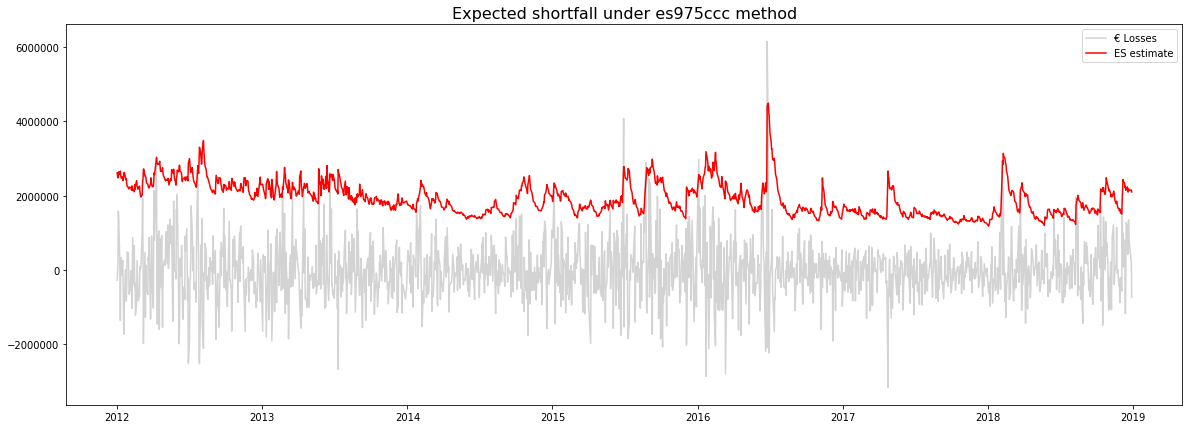

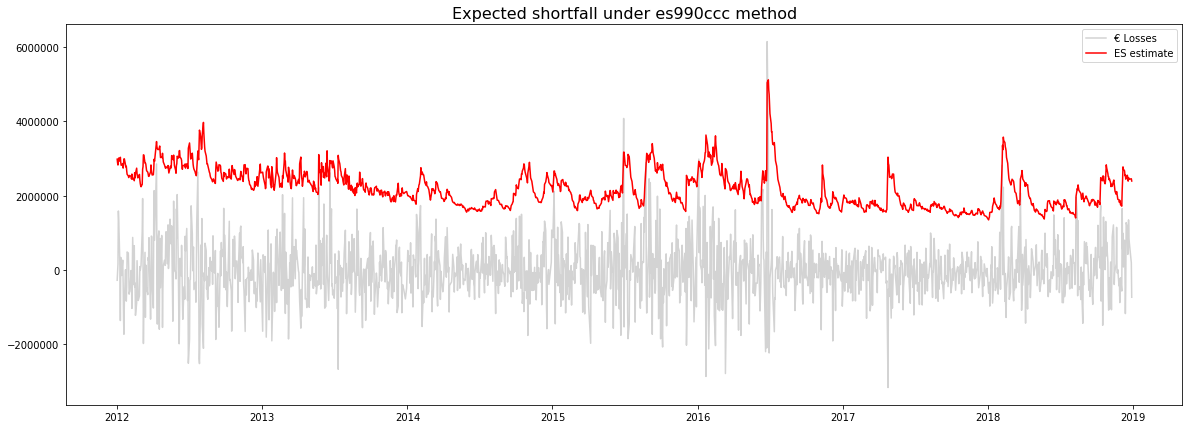

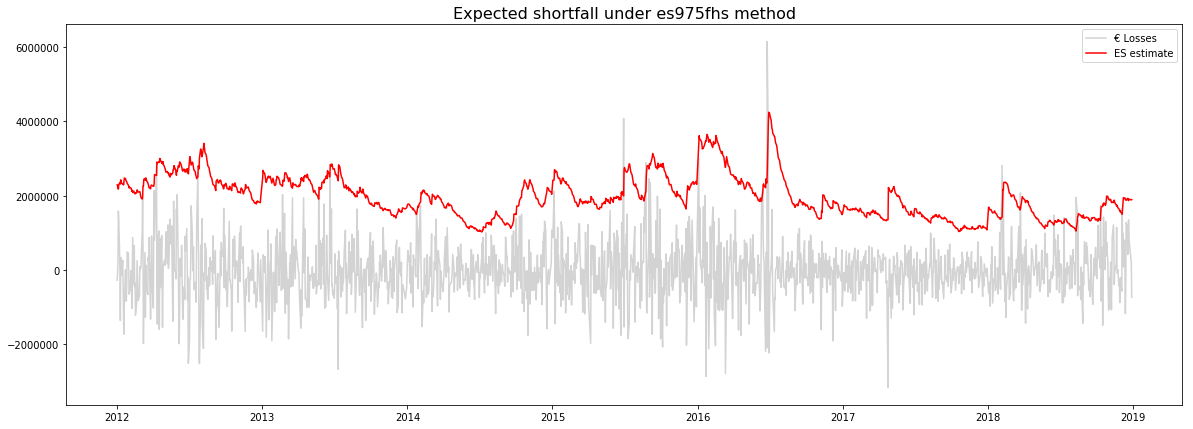

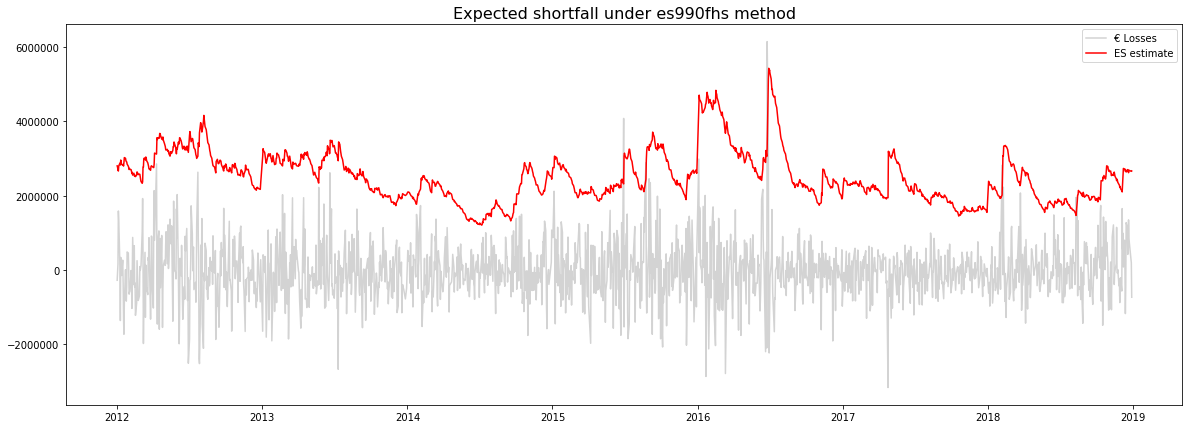

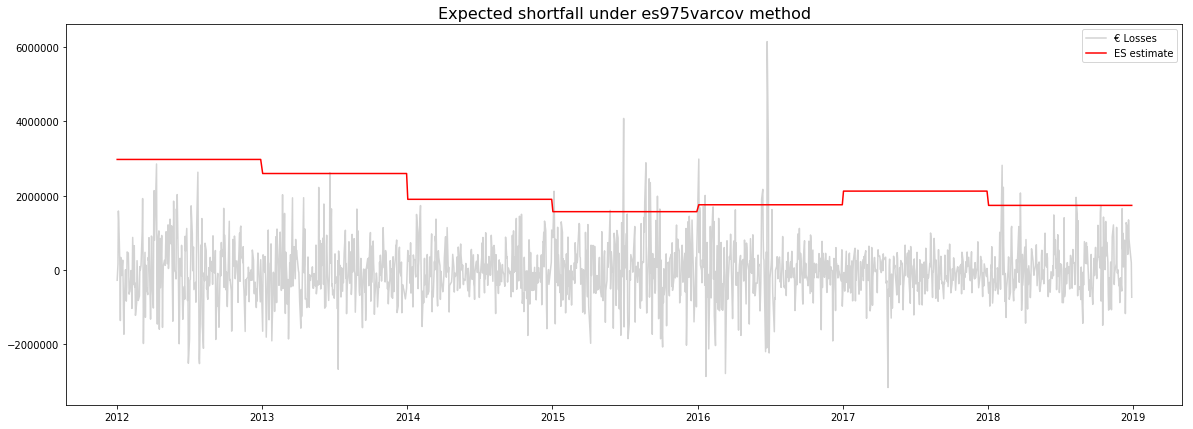

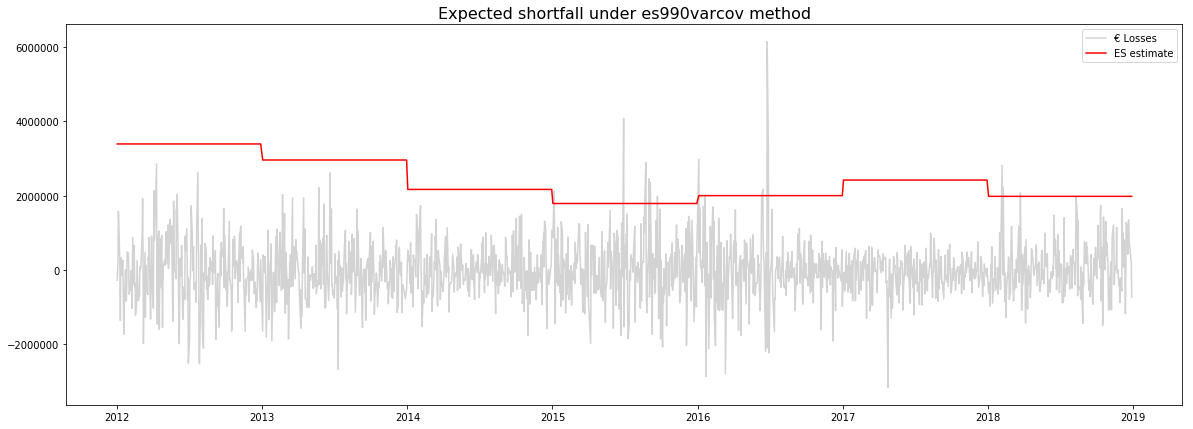

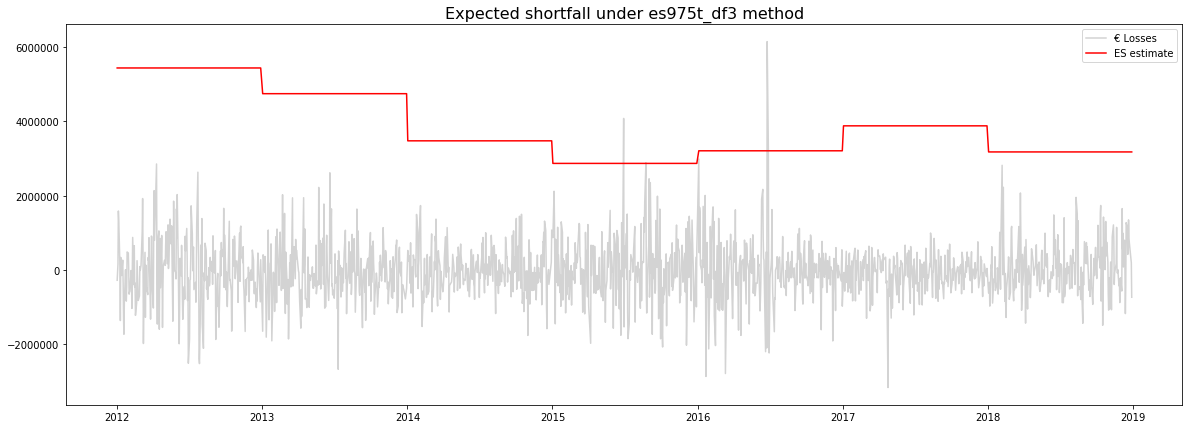

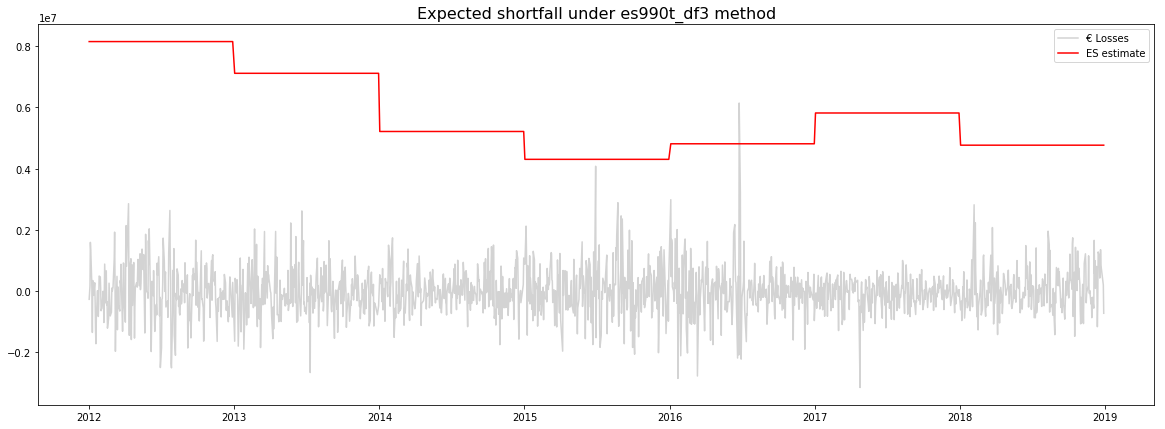

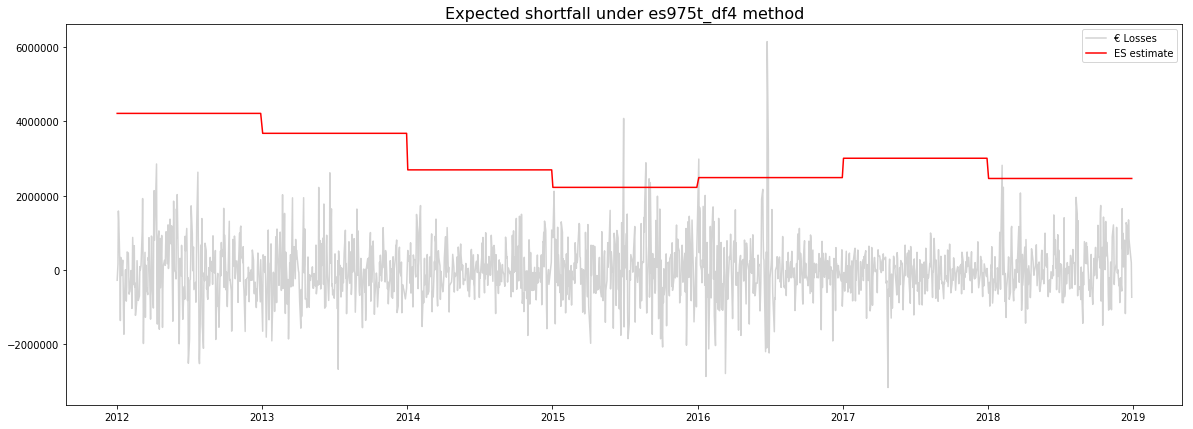

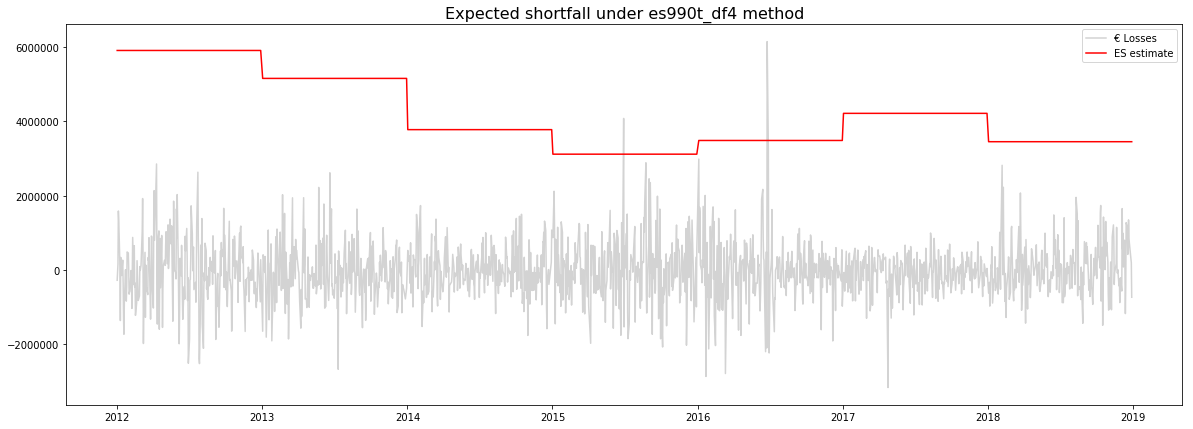

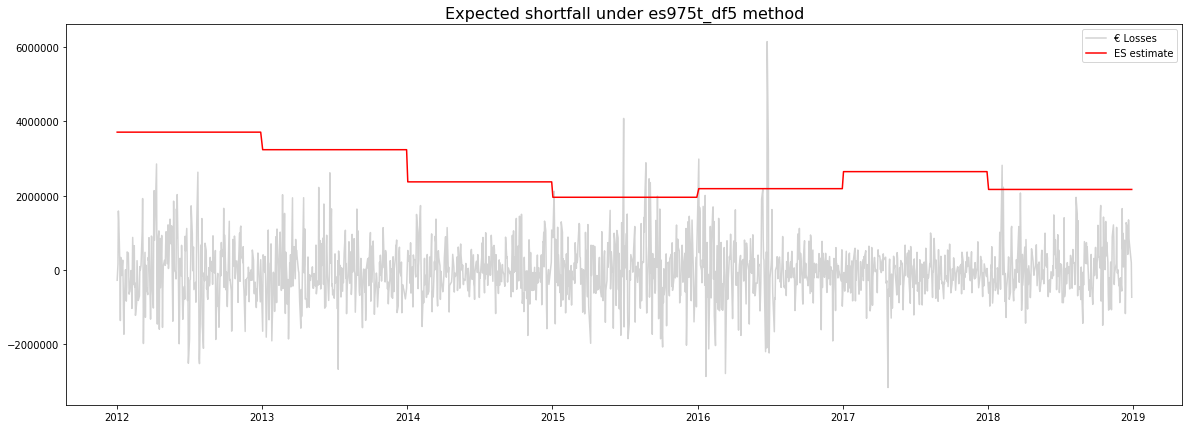

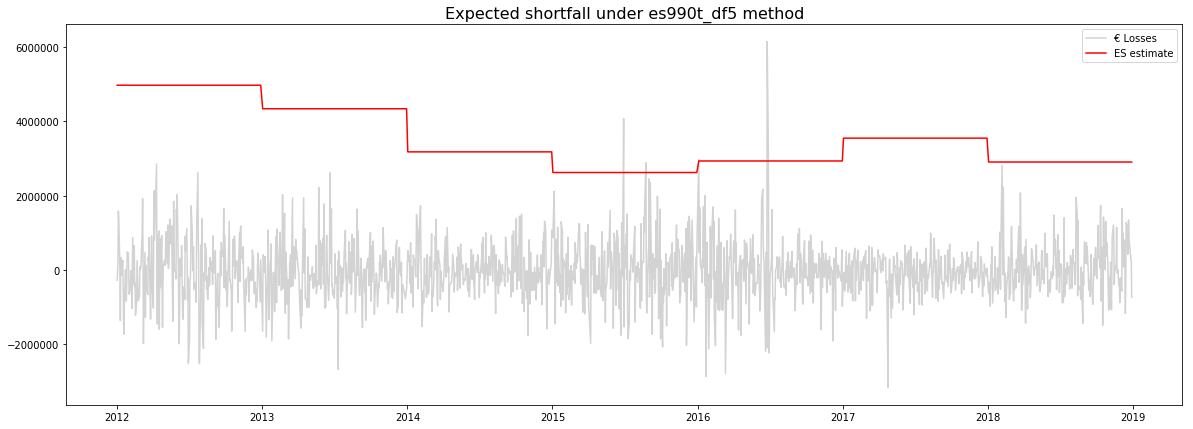

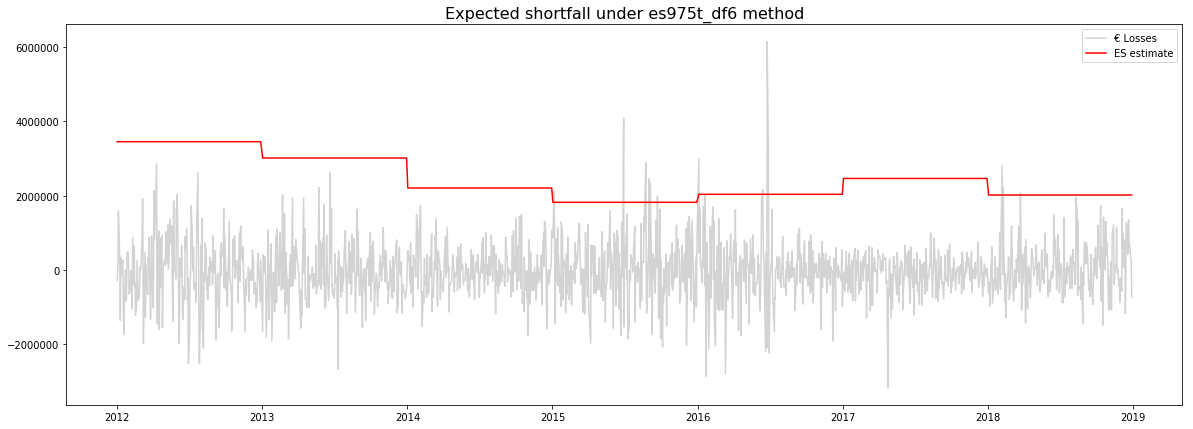

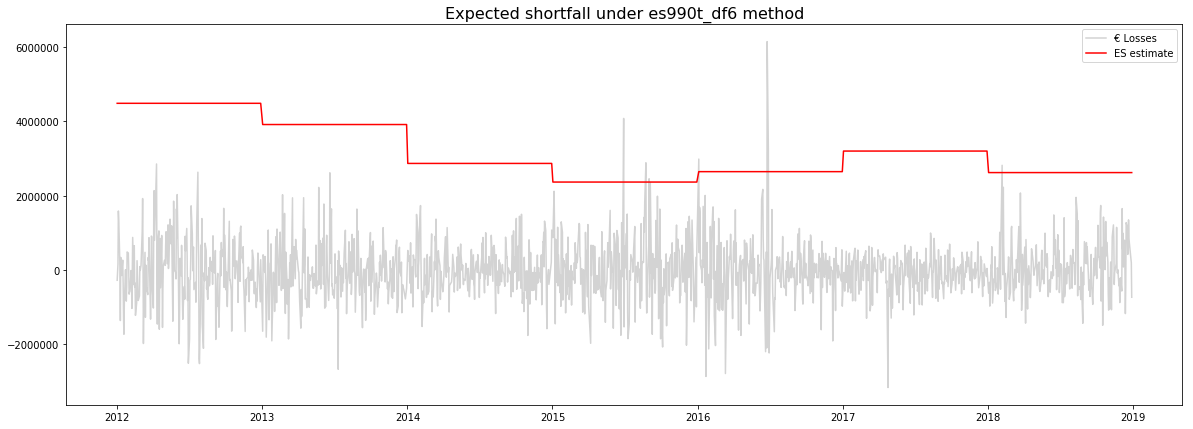

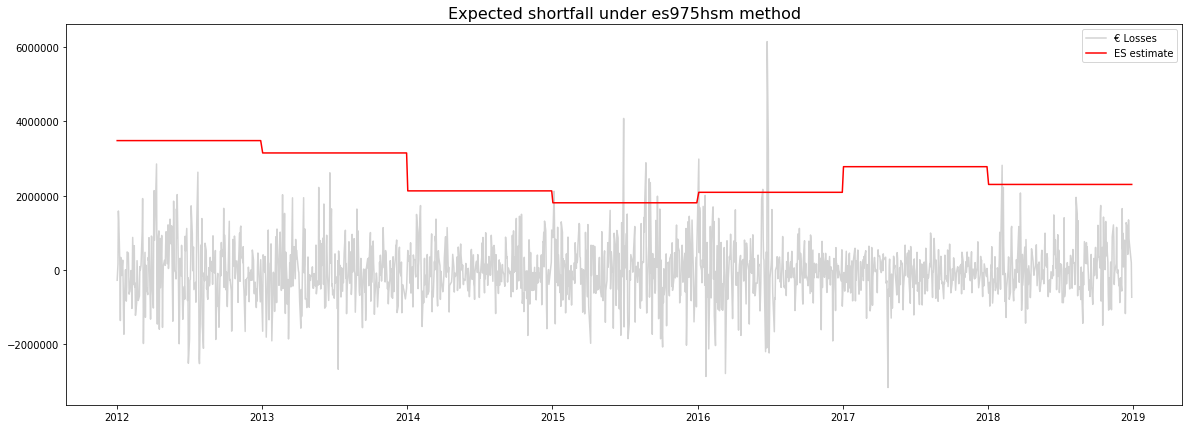

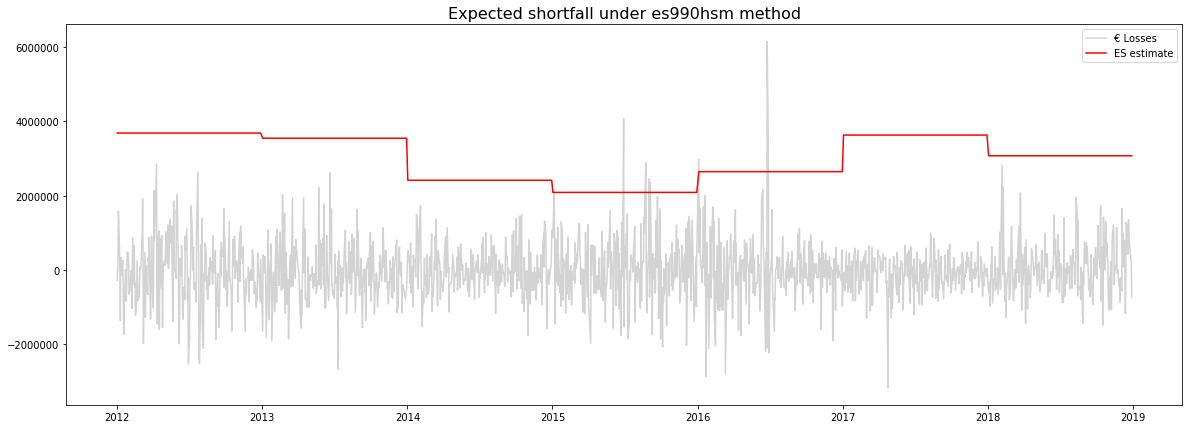

In [70]:
# Plot estimated expected shortfall against empirical losses
for measure in backtest_es.iloc[:,1:17]:

    measure_violation = str(measure) + '_violations'
    
    x = backtest_es.index
    y1 = backtest_es['Losses']
    y2 = backtest_es[measure]

    fig, ax = plt.subplots(figsize=(20, 7))

    plt.title('Expected shortfall under {} method'.format(measure), size=16)

    # Plot returns in euro
    plt.plot(x, y1, color='lightgrey', label = '\u20ac Losses')
    
    # Plot VaR
    plt.plot(x, y2, color='red', label = 'ES estimate')
        
    plt.legend();

In [71]:
# Average ES estimate per year per method
backtest_es.groupby(backtest_es.index.year).mean()

,Losses,es975ccc,es990ccc,es975fhs,es990fhs,es975varcov,es990varcov,es975t_df3,es990t_df3,es975t_df4,es990t_df4,es975t_df5,es990t_df5,es975t_df6,es990t_df6,es975hsm,es990hsm
Date,,,,,,,,,,,,,,,,,
2012,-53501.467510,2.403762e+06,2.740412e+06,2.430106e+06,2.970707e+06,2.974664e+06,3.391269e+06,5.435544e+06,8.156271e+06,4.213490e+06,5.906305e+06,3.708874e+06,4.971188e+06,3.451930e+06,4.484686e+06,3.481342e+06,3.684353e+06
2013,-93051.523151,2.068900e+06,2.358651e+06,2.162183e+06,2.663198e+06,2.596076e+06,2.959659e+06,4.743757e+06,7.118215e+06,3.677235e+06,5.154604e+06,3.236842e+06,4.338500e+06,3.012599e+06,3.913916e+06,3.149429e+06,3.545440e+06
2014,4346.698986,1.751894e+06,1.997249e+06,1.634686e+06,1.938642e+06,1.901929e+06,2.168296e+06,3.475357e+06,5.214924e+06,2.694005e+06,3.776350e+06,2.371365e+06,3.178458e+06,2.207081e+06,2.867401e+06,2.129023e+06,2.414436e+06
2015,22502.069779,1.929703e+06,2.199960e+06,2.200582e+06,2.535689e+06,1.569565e+06,1.789385e+06,2.868035e+06,4.303612e+06,2.223225e+06,3.116430e+06,1.956967e+06,2.623020e+06,1.821392e+06,2.366320e+06,1.808423e+06,2.087898e+06
2016,-14217.160779,2.005910e+06,2.286840e+06,2.411914e+06,3.159107e+06,1.755216e+06,2.001035e+06,3.207270e+06,4.812649e+06,2.486191e+06,3.485045e+06,2.188440e+06,2.933275e+06,2.036829e+06,2.646212e+06,2.090368e+06,2.645654e+06
2017,-83778.551958,1.509992e+06,1.721468e+06,1.466288e+06,2.086531e+06,2.122637e+06,2.419915e+06,3.878653e+06,5.820087e+06,3.006629e+06,4.214574e+06,2.646549e+06,3.547301e+06,2.463201e+06,3.200147e+06,2.779684e+06,3.630056e+06
2018,49120.804523,1.760059e+06,2.006557e+06,1.567657e+06,2.202607e+06,1.738490e+06,1.981967e+06,3.176708e+06,4.766788e+06,2.462500e+06,3.451835e+06,2.167586e+06,2.905323e+06,2.017419e+06,2.620996e+06,2.302127e+06,3.073343e+06


#### Historical simulation for different horizons ####

In [72]:
# Sum the losses per 5-days with no overlapping periods
pf_losses_5d = []
# Sum the losses per 10-days with no overlapping periods
pf_losses_10d = []

for loss in range(len(pf_losses)):
    if loss % 5 == 0:
        pf_losses_5d.append(sum(pf_losses[loss-5:loss]))
    if loss % 10 == 0:
        pf_losses_10d.append(sum(pf_losses[loss-10:loss]))

In [73]:
# 5 day empirical VaR
var_975_5d_hsm = np.percentile(pf_losses_5d, confidence_levels[0] * 100)
var_990_5d_hsm = np.percentile(pf_losses_5d, confidence_levels[1] * 100)

# 10 day empirical VaR
var_975_10d_hsm = np.percentile(pf_losses_10d, confidence_levels[0] * 100)
var_990_10d_hsm = np.percentile(pf_losses_10d, confidence_levels[1] * 100)

In [74]:
hsm975 = np.average(rolling_var.get('var975hsm'))
hsm990 = np.average(rolling_var.get('var990hsm'))

VaR measure,$\sqrt{t}$ rule,empirical
VaR with 97.5% confidence,,
10d,6.055534,6.437061
5d,4.281909,4.792859


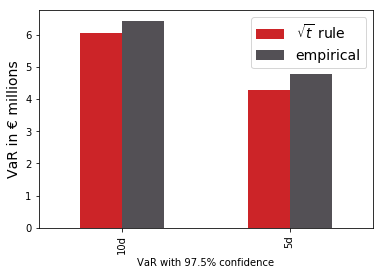

In [75]:
# Compare the empirical 5- and 10-day VaRs with the VaRs obtained with the squared time rule at 97.5% confidence

df = pd.DataFrame([['empirical','5d',var_975_5d_hsm / 1000000],['empirical','10d',var_975_10d_hsm / 1000000],
                    [r'$\sqrt{t}$ rule','5d',hsm975 * np.sqrt(5) / 1000000],[r'$\sqrt{t}$ rule','10d',hsm975 * np.sqrt(10) / 1000000]],columns=['VaR measure','VaR with 97.5% confidence','val'])

barplot_data = df.pivot("VaR with 97.5% confidence", "VaR measure", "val")

barplot_data.plot(kind='bar', color=['#CC2428','#535055'])
plt.ylabel('VaR in \u20ac millions', size=14)
plt.legend(fontsize=14)

plt.savefig('sqrt_time_975', dpi=400, bbox_inches='tight')

barplot_data

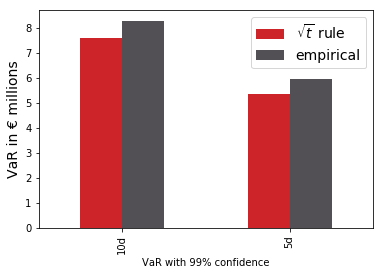

In [76]:
# Compare the empirical 5- and 10-day VaRs with the VaRs obtained with the squared time rule at 99% confidence

df = pd.DataFrame([['empirical','5d',var_990_5d_hsm / 1000000],['empirical','10d',var_990_10d_hsm / 1000000],
                    [r'$\sqrt{t}$ rule','5d',hsm990 * np.sqrt(5) / 1000000],[r'$\sqrt{t}$ rule','10d',hsm990 * np.sqrt(10) / 1000000]],columns=['VaR measure','VaR with 99% confidence','val'])

df.pivot("VaR with 99% confidence", "VaR measure", "val").plot(kind='bar', color=['#CC2428','#535055']);
plt.ylabel('VaR in \u20ac millions', size=14)
plt.legend(fontsize=14);

plt.savefig('sqrt_time_990', dpi=400, bbox_inches='tight')

### Stress Testing VaR

In [77]:
# Define shocks
# Define the types of instruments in the portfolio

equity = ['AEX','EWQ','GSPC', 'N225']
commodity = ['DBA']
currency = ['EURJPY=X', 'EURUSD=X']
interestRate = ['euribor3m']

shocks = [equity,commodity,currency,interestRate]
shocks=[equity, commodity]


In [78]:
# Define testing period

import datetime
import random

# Define the duration of the shock
shock_duration = datetime.timedelta(5)

# Set a seed for random implementation
random.seed(9999)

shock_date = random.choice(test_set.index)

In [79]:
def convert_stressedPrice_to_loss(df_prices, shock, multiplier, principle=principle, weights=weights, shock_date=shock_date,shock_duration=shock_duration):
    
    '''
    convert the normal prices to stressed returns, then to stressed portfolio losses
    
    '''
    df_returns_all=pd.DataFrame(columns=df_prices.columns)
    
    df_returns_all = np.log(df_prices) - np.log(df_prices.shift())
    
    if shock == interestRate:
        # the interest rate shock is applied to the log return of the interest rate future linearly
        # because the shock is a parallel shift in the yield
        df_returns_all.loc[shock_date:shock_date+shock_duration,shock] = df_returns_all.loc[shock_date:shock_date+shock_duration,shock] + m
        
    else:
        
        # apply the shocks to the asset prices for shocks that not interest rate shock
        # the asset prices are multiplied by the shock multiplier
        df_returns_all.loc[shock_date:shock_date+shock_duration,shock] = np.log(df_prices.loc[shock_date:shock_date+shock_duration,shock]* m) - np.log(df_prices.loc[shock_date:shock_date+shock_duration, shock].shift())
        
    # get the instrument returns
    df_returns = df_returns_all[instrument_names]
    
    # adjust for exchange rates
    df_returns['DBA'] = df_returns['DBA'] + df_returns_all['EURUSD=X']
    df_returns['EWQ'] = df_returns['EWQ'] + df_returns_all['EURUSD=X']
    df_returns['GSPC'] = df_returns['GSPC'] + df_returns_all['EURUSD=X']
    df_returns['N225'] = df_returns['N225'] + df_returns_all['EURJPY=X']
    
    # generate a df of the stressed returns in monetary terms
    test_losses = - (df_returns*weights).sum(axis=1)
    test_losses = pd.DataFrame(data=test_losses)
    test_losses.columns = ['Losses']
    
    return test_losses*principle

In [80]:
# Define a function that backtests the VaR and returns a test statistic
# With the test statistic it can be determined if the number of expected violations
# are significantly different from the VaRs prediction. 
def test_VaR(VaR, test_period, confidence_level, return_type = 'pvalue'):
    '''
    
    statistically test the number of violations
    
    test_period: Portfolio Losses -> pd.Series
    
    '''
    temp = pd.DataFrame(test_period, index = test_period.index)
    temp['VaR'] = VaR
    
    # generate the violations
    temp['count'] = np.where(temp['Losses'] > temp['VaR'], temp['Losses'], 'NaN')
    temp['count'] = temp['count'].astype(float)
    
    # construct the test statistics
    alpha = 1- confidence_level
    N = len(test_period)
    violations = temp['count'].count()
    expected = N * (alpha)

    zscore = (violations - expected) / np.sqrt(N * alpha * (1 - alpha))

    pvalue = norm.sf(abs(zscore)) * 2
    
    if return_type == 'pvalue':
        return pvalue
    
    elif return_type == 'zscore':
        return zscore

In [81]:
VaRs = backtest.columns[1:17]

In [82]:
# create a dataframe to record the stress testing results

results_stressTesting=pd.DataFrame(columns=VaRs)

In [83]:
# equity shock
shock = equity
shock_multipliers = [1.2, 0.8, 1.4, 0.6]


print(f'VaR Stress Testing {shock}\n')
for m in shock_multipliers:


    # apply the shock to risk factors

    
    # calculate the corresponding portfolio losses
    test_losses = convert_stressedPrice_to_loss(df_pf, shock=shock, multiplier = m, principle=principle, weights=weights)
    
    # calculate the VaR
    
    
    for col in VaRs:
        # calculate the violations
        if col[3:6] == '975':
            pvalue = test_VaR(backtest[col], test_losses, confidence_levels[0], 'pvalue')
            zscore = test_VaR(backtest[col], test_losses, confidence_levels[0], 'zscore')
        elif col[3:6] == '990':
            pvalue = test_VaR(backtest[col], test_losses, confidence_levels[1], 'pvalue')
            zscore = test_VaR(backtest[col], test_losses, confidence_levels[1], 'zscore')
        
        print(f'{col}: shock multiplier: {m}\ntest statistic: {zscore:.5f}\np-value: {pvalue:.3f}\n')


VaR Stress Testing ['AEX', 'EWQ', 'GSPC', 'N225']

var975ccc: shock multiplier: 1.2
test statistic: -4.58193
p-value: 0.000

var990ccc: shock multiplier: 1.2
test statistic: -3.33798
p-value: 0.001

var975fhs: shock multiplier: 1.2
test statistic: -0.29788
p-value: 0.766

var990fhs: shock multiplier: 1.2
test statistic: -1.44737
p-value: 0.148

var975varcov: shock multiplier: 1.2
test statistic: -2.17215
p-value: 0.030

var990varcov: shock multiplier: 1.2
test statistic: -0.39703
p-value: 0.691

var975t_df3: shock multiplier: 1.2
test statistic: -6.59008
p-value: 0.000

var990t_df3: shock multiplier: 1.2
test statistic: -4.38832
p-value: 0.000

var975t_df4: shock multiplier: 1.2
test statistic: -5.92069
p-value: 0.000

var990t_df4: shock multiplier: 1.2
test statistic: -3.54805
p-value: 0.000

var975t_df5: shock multiplier: 1.2
test statistic: -5.51906
p-value: 0.000

var990t_df5: shock multiplier: 1.2
test statistic: -3.12791
p-value: 0.002

var975t_df6: shock multiplier: 1.2
test sta

In [84]:
# currency shock
shock = currency
shock_multipliers = [1.1, 0.9, 1.2, 0.8]


print(f'VaR Stress Testing {shock}\n')
for m in shock_multipliers:


    # apply the shock to risk factors

    
    # calculate the corresponding portfolio losses
    test_losses = convert_stressedPrice_to_loss(df_pf, shock=shock, multiplier = m, principle=principle, weights=weights)
    
    # calculate the VaR
    
    
    for col in VaRs:
        # calculate the violations
        if col[3:6] == '975':
            pvalue = test_VaR(backtest[col], test_losses, confidence_levels[0], 'pvalue')
            zscore = test_VaR(backtest[col], test_losses, confidence_levels[0], 'zscore')
        elif col[3:6] == '990':
            pvalue = test_VaR(backtest[col], test_losses, confidence_levels[1], 'pvalue')
            zscore = test_VaR(backtest[col], test_losses, confidence_levels[1], 'zscore')
        
        print(f'{col}: shock multiplier: {m}\ntest statistic: {zscore:.5f}\np-value: {pvalue:.3f}\n')


VaR Stress Testing ['EURJPY=X', 'EURUSD=X']

var975ccc: shock multiplier: 1.1
test statistic: -4.58193
p-value: 0.000

var990ccc: shock multiplier: 1.1
test statistic: -3.33798
p-value: 0.001

var975fhs: shock multiplier: 1.1
test statistic: -0.29788
p-value: 0.766

var990fhs: shock multiplier: 1.1
test statistic: -1.44737
p-value: 0.148

var975varcov: shock multiplier: 1.1
test statistic: -2.17215
p-value: 0.030

var990varcov: shock multiplier: 1.1
test statistic: -0.39703
p-value: 0.691

var975t_df3: shock multiplier: 1.1
test statistic: -6.59008
p-value: 0.000

var990t_df3: shock multiplier: 1.1
test statistic: -4.38832
p-value: 0.000

var975t_df4: shock multiplier: 1.1
test statistic: -5.92069
p-value: 0.000

var990t_df4: shock multiplier: 1.1
test statistic: -3.54805
p-value: 0.000

var975t_df5: shock multiplier: 1.1
test statistic: -5.51906
p-value: 0.000

var990t_df5: shock multiplier: 1.1
test statistic: -3.12791
p-value: 0.002

var975t_df6: shock multiplier: 1.1
test statistic

In [85]:
# commodity shock
shock = commodity
shock_multipliers = [1.2, 0.8, 1.4, 0.6]

print(f'VaR Stress Testing {shock}\n')
for m in shock_multipliers:


    # apply the shock to risk factors

    
    # calculate the corresponding portfolio losses
    test_losses = convert_stressedPrice_to_loss(df_pf, shock=shock, multiplier = m, principle=principle, weights=weights)
    
    # calculate the VaR
    
    
    for col in VaRs:
        # calculate the violations
        if col[3:6] == '975':
            pvalue = test_VaR(backtest[col], test_losses, confidence_levels[0], 'pvalue')
            zscore = test_VaR(backtest[col], test_losses, confidence_levels[0], 'zscore')
        elif col[3:6] == '990':
            pvalue = test_VaR(backtest[col], test_losses, confidence_levels[1], 'pvalue')
            zscore = test_VaR(backtest[col], test_losses, confidence_levels[1], 'zscore')
        
        print(f'{col}: shock multiplier: {m}\ntest statistic: {zscore:.5f}\np-value: {pvalue:.3f}\n')

VaR Stress Testing ['DBA']

var975ccc: shock multiplier: 1.2
test statistic: -4.58193
p-value: 0.000

var990ccc: shock multiplier: 1.2
test statistic: -3.33798
p-value: 0.001

var975fhs: shock multiplier: 1.2
test statistic: -0.29788
p-value: 0.766

var990fhs: shock multiplier: 1.2
test statistic: -1.44737
p-value: 0.148

var975varcov: shock multiplier: 1.2
test statistic: -2.17215
p-value: 0.030

var990varcov: shock multiplier: 1.2
test statistic: -0.39703
p-value: 0.691

var975t_df3: shock multiplier: 1.2
test statistic: -6.59008
p-value: 0.000

var990t_df3: shock multiplier: 1.2
test statistic: -4.38832
p-value: 0.000

var975t_df4: shock multiplier: 1.2
test statistic: -5.92069
p-value: 0.000

var990t_df4: shock multiplier: 1.2
test statistic: -3.54805
p-value: 0.000

var975t_df5: shock multiplier: 1.2
test statistic: -5.51906
p-value: 0.000

var990t_df5: shock multiplier: 1.2
test statistic: -3.12791
p-value: 0.002

var975t_df6: shock multiplier: 1.2
test statistic: -5.38519
p-valu

In [86]:
# interest rate shock
shock = interestRate
shock_multipliers = [0.02, -0.02, 0.03, -0.03]

print(f'VaR Stress Testing {shock}\n')
for m in shock_multipliers:


    # apply the shock to risk factors

    
    # calculate the corresponding portfolio losses
    test_losses = convert_stressedPrice_to_loss(df_pf, shock=shock, multiplier = m, principle=principle, weights=weights)
    
    # calculate the VaR
    
    
    for col in VaRs:
        # calculate the violations
        if col[3:6] == '975':
            pvalue = test_VaR(backtest[col], test_losses, confidence_levels[0], 'pvalue')
            zscore = test_VaR(backtest[col], test_losses, confidence_levels[0], 'zscore')
        elif col[3:6] == '990':
            pvalue = test_VaR(backtest[col], test_losses, confidence_levels[1], 'pvalue')
            zscore = test_VaR(backtest[col], test_losses, confidence_levels[1], 'zscore')
        
        print(f'{col}: shock multiplier: {m}\ntest statistic: {zscore:.5f}\np-value: {pvalue:.3f}\n')

VaR Stress Testing ['euribor3m']

var975ccc: shock multiplier: 0.02
test statistic: -4.58193
p-value: 0.000

var990ccc: shock multiplier: 0.02
test statistic: -3.33798
p-value: 0.001

var975fhs: shock multiplier: 0.02
test statistic: -0.29788
p-value: 0.766

var990fhs: shock multiplier: 0.02
test statistic: -1.44737
p-value: 0.148

var975varcov: shock multiplier: 0.02
test statistic: -2.17215
p-value: 0.030

var990varcov: shock multiplier: 0.02
test statistic: -0.39703
p-value: 0.691

var975t_df3: shock multiplier: 0.02
test statistic: -6.59008
p-value: 0.000

var990t_df3: shock multiplier: 0.02
test statistic: -4.38832
p-value: 0.000

var975t_df4: shock multiplier: 0.02
test statistic: -5.92069
p-value: 0.000

var990t_df4: shock multiplier: 0.02
test statistic: -3.54805
p-value: 0.000

var975t_df5: shock multiplier: 0.02
test statistic: -5.51906
p-value: 0.000

var990t_df5: shock multiplier: 0.02
test statistic: -3.12791
p-value: 0.002

var975t_df6: shock multiplier: 0.02
test statist